In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
from sklearn.model_selection import train_test_split
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")


/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using device: cpu


## Data set import

In [2]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

### gen data

In [3]:
def genData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    """data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data.X=np.concatenate([data.X,data2.X])
    data.y=np.concatenate([data.y,data2.y])
    del data2
    data3=loaded(to,filename="X_data_newMorph.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data3.X])
    data.y=np.concatenate([data.y,data3.y])
    del data3"""
    #data.resize(percentage)
    #data.augment()
    data.shuffle()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_data_newMorph.npz")
    #d.applySobel()
    #p20=d.X[np.where(d.y==3)]
    #data.X=np.concatenate([data.X,p20])
    #data.y=np.concatenate([data.y,np.zeros((len(p20)))+11])
    #data.resize(percentage)
    print("LOADED DATASET...")
    #data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader

def genDataANN(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    data.shuffle()
    data.resize(percentage)
    print("LOADED DATASET...")
    data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to)*data.X.shape[2]*data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader
def gen3DData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_nomarker.npz")
    #data.applySobel()
    #data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    #data3=loaded(to,filename="X_data_gel_15.npz")
    #data3.applySobel()
    #data.X=np.concatenate([data.X,data2.X,data3.X])
    #data.y=np.concatenate([data.y,data2.y,data3.y])
    #del data2
    #del data3
    data.augment()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
    #d.applySobel()
    #data.augment()
    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genCNNLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3
    data.augment()

    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width,output=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten_size = 10 * (input_height // 4) * (input_width // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class SimpleANN(nn.Module):
    def __init__(self,input, hidden,output=15):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
class Simple3DCNN(nn.Module):
    def __init__(self, input_depth, input_height, input_width):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        depth = input_depth
        height = input_height
        width = input_width
        
        depth = depth // 2  # after first pooling
        height = height // 2
        width = width // 2
        
        depth = depth // 2  # after second pooling
        height = height // 2
        width = width // 2
        
        # Number of output features from conv layers (channels * depth * height * width)
        self.flatten_size = 10 * depth * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class CNN_LSTM(nn.Module):
    def __init__(self, input_width, input_height, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )
        
        # Calculate the CNN output size
        cnn_output_size = self._get_cnn_output_size(input_width, input_height)
        
        # Define the LSTM part
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def _get_cnn_output_size(self, width, height):
        # Create a dummy tensor with the given width and height
        dummy_input = torch.zeros(1, 1, height, width)
        
        # Pass the dummy tensor through the CNN
        dummy_output = self.cnn(dummy_input)
        
        # Calculate the output size by flattening the output
        return dummy_output.view(-1).size(0)
    
    def forward(self, x):
        batch_size, c, sequence_length, h, w = x.size()
        # Reshape input to (batch_size * sequence_length, c, h, w) for CNN
        c_in = x.view(batch_size * sequence_length, c, h, w)
        
        # Pass through CNN
        c_out = self.cnn(c_in)
        
        # Flatten the CNN output
        c_out = c_out.view(c_out.size(0), -1)
        
        # Reshape to (batch_size, sequence_length, cnn_output_size) for LSTM
        lstm_in = c_out.view(batch_size, sequence_length, -1)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(lstm_in)
        
        # Get the output from the last time step
        output = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(output)
        
        return output
    


## Train

In [5]:
def run(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleCNN(image.shape[0],image.shape[1],output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def runANN(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0]
    output=len(next(iter(train_loader))[1][0])
    print("SHAPE....",image.shape)
    model = SimpleANN(image.shape[0],400,output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def run3D(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = Simple3DCNN(image.shape[0],image.shape[1],image.shape[2]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed
def runLSTM(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleLSTM(image.shape[0],50,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def runLSTMcnn(train_loader,frm,to,num_epochs=150):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = CNN_LSTM(image.shape[1],image.shape[0],1000,1,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

### ANN train

In [ ]:
torch.cuda.empty_cache()
train_loader,test_loader=genDataANN(0,4)

In [19]:
model,history=runANN(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelANN") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelANN")

SHAPE.... torch.Size([52800])
Epoch [1/100], Step [126/126], Loss: 326.0989
Epoch [11/100], Step [126/126], Loss: 48.6963
Epoch [21/100], Step [126/126], Loss: 10.7879
Epoch [31/100], Step [126/126], Loss: 4.1095
Epoch [41/100], Step [126/126], Loss: 2.2306
Epoch [51/100], Step [126/126], Loss: 1.4487
Epoch [61/100], Step [126/126], Loss: 1.0434
Epoch [71/100], Step [126/126], Loss: 0.7963
Epoch [81/100], Step [126/126], Loss: 0.6393
Epoch [91/100], Step [126/126], Loss: 0.5283
Finished Training
Accuracy: 99.9920641218951 %
0.999920641218951
Accuracy: 99.99801591238268 %
0.9999801591238269


### CNN train

In [14]:
torch.cuda.empty_cache()
train_loader,test_loader=genData(0,4)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodel_newMorph") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 1.93 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_195787/702361806.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [42/42], Loss: 113.6217
Epoch [11/100], Step [42/42], Loss: 63.4683
Epoch [21/100], Step [42/42], Loss: 34.3336
Epoch [31/100], Step [42/42], Loss: 22.4750
Epoch [41/100], Step [42/42], Loss: 16.1262
Epoch [51/100], Step [42/42], Loss: 13.4916
Epoch [61/100], Step [42/42], Loss: 10.1517
Epoch [71/100], Step [42/42], Loss: 8.5218
Epoch [81/100], Step [42/42], Loss: 6.9260
Epoch [91/100], Step [42/42], Loss: 6.0048
Finished Training
Accuracy: 95.92954058557486 %
0.9592954058557486
Accuracy: 97.79179810725552 %
0.9779179810725552


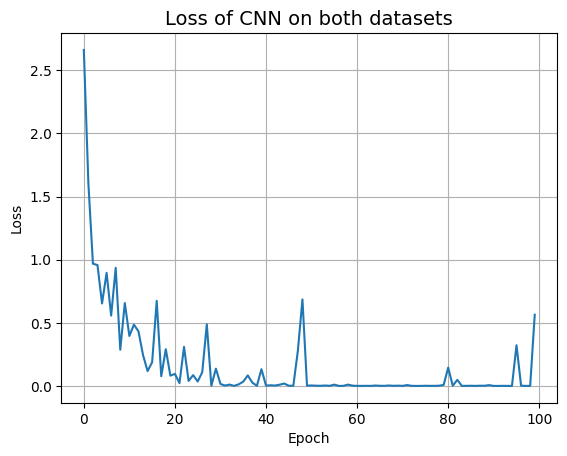

In [8]:
plt.plot(history)
plt.grid(True)
plt.title("Loss of CNN on both datasets",fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+"/images/loss_of_uber_model.pdf")
plt.show()

In [48]:
train_loader,test_loader,unique=genData(0,4)
data=loaded(4,filename="X_data_newMorph.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=13).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()

Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 4 
Image: (110, 120)
Memory needed: 0.38 GB
Memory left 1.93 GB
Using 2.15 GB
torch.Size([5460, 1, 440, 120])
torch.Size([5460, 13])


/tmp/ipykernel_21459/1734164554.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
)

In [ ]:


ar=[]
acc=[]
for i in range(5):
    try:
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4)
        model,history=run(train_loader,0,4)
        ar.append(history)
        print(calc(model,test_loader))
        print(calc(model,train_loader))
        acc.append(calc(model,test_loader))
        if acc[-1]>=max(acc):
            torch.save(model.state_dict(), path+"/model/mymmodel_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
    except MemoryError as e:
        try:
            del train_loader
            del test_loader
            del model
        except: 
            pass
ar=np.array(ar)
acc=np.array(acc)


np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/accuracies_of_NM_uber",acc)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/loss_of_NM_uber",ar)

In [10]:
#T EXPERIEMTN

ar_=[]
acc_=[]
for j in range(1,20,2):
    clear_output(wait=True)
    print("t SIZE:",j)
    ar=[]
    acc=[]
    for i in range(3):
        try:
            torch.cuda.empty_cache()
            train_loader,test_loader,unique=genLSTMData(0,j)
            model,history=runLSTM(train_loader,0,j)
            ar.append(history)
            print(calc(model,test_loader))
            print(calc(model,train_loader))
            acc.append(calc(model,test_loader))
            if acc[-1]>=max(acc):
                torch.save(model.state_dict(), path+"/models/lstm_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
            del train_loader
            del test_loader
            del model
        except MemoryError as e:
            try:
                del train_loader
                del test_loader
                del model
            except: 
                pass
    ar=np.array(ar)
    acc=np.array(acc)
    ar_.append(ar)
    acc_.append(acc)
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMaccuracies_of_NM_uber",np.array(acc_))
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMloss_of_NM_uber",np.array(ar_))

t SIZE: 19
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 19 
Image: (110, 120)
Memory needed: 2.1 GB
Memory left 12.0 GB
Using 16.82 GB
torch.Size([8999, 19, 13200])
torch.Size([8999, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_11424\2858333306.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 445.2877
Epoch [11/100], Step [180/180], Loss: 21.6610
Epoch [21/100], Step [180/180], Loss: 2.6546
Epoch [31/100], Step [180/180], Loss: 1.2255
Epoch [41/100], Step [180/180], Loss: 0.7699
Epoch [51/100], Step [180/180], Loss: 0.5524
Epoch [61/100], Step [180/180], Loss: 0.4269
Epoch [71/100], Step [180/180], Loss: 0.3459
Epoch [81/100], Step [180/180], Loss: 0.2896
Epoch [91/100], Step [180/180], Loss: 0.2484
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.99861093747829 %
0.9999861093747829
Accuracy: 99.99444475306927 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 19 
Image: (110, 120)
Memory needed: 2.1 GB
Memory left 12.0 GB
Using 16.82 GB
torch.Size([8999, 19, 13200])
torch.Size([8999, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_11424\2858333306.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 444.8525
Epoch [11/100], Step [180/180], Loss: 24.5731
Epoch [21/100], Step [180/180], Loss: 2.7152
Epoch [31/100], Step [180/180], Loss: 1.2665
Epoch [41/100], Step [180/180], Loss: 0.7970
Epoch [51/100], Step [180/180], Loss: 0.5702
Epoch [61/100], Step [180/180], Loss: 0.4403
Epoch [71/100], Step [180/180], Loss: 0.3563
Epoch [81/100], Step [180/180], Loss: 0.2979
Epoch [91/100], Step [180/180], Loss: 0.2552
Finished Training
Accuracy: 99.99444475306927 %
0.9999444475306928
Accuracy: 99.99861093747829 %
0.9999861093747829
Accuracy: 99.99444475306927 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 19 
Image: (110, 120)
Memory needed: 2.1 GB
Memory left 12.0 GB
Using 16.82 GB
torch.Size([8999, 19, 13200])
torch.Size([8999, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_11424\2858333306.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 446.7888
Epoch [11/100], Step [180/180], Loss: 27.1272
Epoch [21/100], Step [180/180], Loss: 2.6255
Epoch [31/100], Step [180/180], Loss: 1.2005
Epoch [41/100], Step [180/180], Loss: 0.7514
Epoch [51/100], Step [180/180], Loss: 0.5378
Epoch [61/100], Step [180/180], Loss: 0.4146
Epoch [71/100], Step [180/180], Loss: 0.3346
Epoch [81/100], Step [180/180], Loss: 0.2797
Epoch [91/100], Step [180/180], Loss: 0.2396
Finished Training
Accuracy: 99.93889228376202 %
0.9993889228376202
Accuracy: 99.99861093747829 %
0.9999861093747829
Accuracy: 99.93889228376202 %


In [28]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores_NM_",test_scores)
        np.save(path+"saves/train_scores_NM",train_scores)




/its/home/drs25/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/its/home/drs25/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


>>>> 1 2 
Max: 0.0 % 
Estimated time left: nan minutes
Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 7800 
Window size: 2 
Image: (110, 120)
Memory needed: 0.19 GB
Memory left 1.93 GB


ValueError: cannot reshape array of size 144144000 into shape (5460,1,110,120)

#### resolution

In [40]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.load(path+"/data/test_resolutions_uber.npy")#np.load(path+"/data/test_resolutions_uber.npy")#np.zeros((len(resolutions),3))
scores_test_NM=np.load(path+"/data/resolutions_uberNM.npy")#np.load(path+"/data/test_resolutions_NM.npy")#np.zeros((len(resolutions),3))
scores_train=np.load(path+"/data/train_resolutions_uber.npy")#np.load(path+"/data/train_resolutions_uber.npy")#np.zeros((len(resolutions),3))
#ind=resolutions.index(0.7)
ind=0
try:
    for i, res in enumerate((resolutions[ind:])): #
        i+=ind
        print("Testing resolution",res)
        for j in range(3): #three trials on each
            torch.cuda.empty_cache()
            train_loader,test_loader=genData(0,4,res)
            model,history=run(train_loader,0,4,num_epochs = 130)
            test_acc=calc(model,test_loader)
            train_acc=calc(model,train_loader)
            #look at other stuff
            del train_loader
            del test_loader
            torch.cuda.empty_cache()
            d=loaded(t=4,filename="X_data_newMorph.npz")
            d.applySobel()
            d.resize(res)
            sample=d.X[0:200]
            x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
            x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
            test=torch.tensor(x, dtype=torch.float32).to(device)
            preds=model(test)
            preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
            a=preds-d.y[0:200]
            scores_test_NM[i][j]=len(a[a==0])/len(preds)
            scores_test[i][j]=test_acc
            scores_train[i][j]=train_acc
            print("\t\t",test_acc*100,"%",train_acc*100,"%",len(a[a==0])/len(preds) *100,"%")
            del model
            del d
            del preds
            del test
except Exception as e:
    print(e)
    print(res)
np.save(path+"/data/test_resolutions_uber_",scores_test)
np.save(path+"/data/train_resolutions_uber_",scores_train)
np.save(path+"/data/train_resolutions_uberNM_",scores_test_NM)

Testing resolution 0.05
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 27000 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 12.0 GB
Using 0.02 GB
torch.Size([18900, 1, 20, 6])
torch.Size([18900, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1024.1645
Epoch [11/130], Step [378/378], Loss: 1023.2468
Epoch [21/130], Step [378/378], Loss: 1022.3941
Epoch [31/130], Step [378/378], Loss: 1019.3871
Epoch [41/130], Step [378/378], Loss: 1002.2928
Epoch [51/130], Step [378/378], Loss: 967.9115
Epoch [61/130], Step [378/378], Loss: 933.8415
Epoch [71/130], Step [378/378], Loss: 916.2453
Epoch [81/130], Step [378/378], Loss: 890.8216
Epoch [91/130], Step [378/378], Loss: 864.8954
Epoch [101/130], Step [378/378], Loss: 833.8416
Epoch [111/130], Step [378/378], Loss: 802.3160
Epoch [121/130], Step [378/378], Loss: 769.1043
Finished Training
Accuracy: 36.63924234808603 %
Accuracy: 37.40054629268325 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 36.63924234808603 % 37.40054629268325 % 13.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1024.1058
Epoch [11/130], Step [378/378], Loss: 1023.0751
Epoch [21/130], Step [378/378], Loss: 1022.2059
Epoch [31/130], Step [378/378], Loss: 1019.7764
Epoch [41/130], Step [378/378], Loss: 1005.5430
Epoch [51/130], Step [378/378], Loss: 963.5575
Epoch [61/130], Step [378/378], Loss: 926.0456
Epoch [71/130], Step [378/378], Loss: 895.8417
Epoch [81/130], Step [378/378], Loss: 846.7271
Epoch [91/130], Step [378/378], Loss: 784.9394
Epoch [101/130], Step [378/378], Loss: 714.8602
Epoch [111/130], Step [378/378], Loss: 648.0358
Epoch [121/130], Step [378/378], Loss: 587.3159
Finished Training
Accuracy: 49.1256845057009 %
Accuracy: 49.61607396776476 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 49.1256845057009 % 49.61607396776476 % 6.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Win

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.9746
Epoch [11/130], Step [378/378], Loss: 1022.9882
Epoch [21/130], Step [378/378], Loss: 1022.1749
Epoch [31/130], Step [378/378], Loss: 1020.0792
Epoch [41/130], Step [378/378], Loss: 1012.3606
Epoch [51/130], Step [378/378], Loss: 976.2415
Epoch [61/130], Step [378/378], Loss: 925.3860
Epoch [71/130], Step [378/378], Loss: 889.2243
Epoch [81/130], Step [378/378], Loss: 856.3081
Epoch [91/130], Step [378/378], Loss: 813.3681
Epoch [101/130], Step [378/378], Loss: 758.1135
Epoch [111/130], Step [378/378], Loss: 698.5701
Epoch [121/130], Step [378/378], Loss: 636.4292
Finished Training
Accuracy: 44.99880955530277 %
Accuracy: 44.9666338185594 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 44.99880955530277 % 44.9666338185594 % 8.5 %
Testing resolution 0.1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1024.4429
Epoch [11/130], Step [378/378], Loss: 1021.8189
Epoch [21/130], Step [378/378], Loss: 1017.9701
Epoch [31/130], Step [378/378], Loss: 990.0688
Epoch [41/130], Step [378/378], Loss: 876.5415
Epoch [51/130], Step [378/378], Loss: 702.2313
Epoch [61/130], Step [378/378], Loss: 538.7926
Epoch [71/130], Step [378/378], Loss: 432.1051
Epoch [81/130], Step [378/378], Loss: 359.7559
Epoch [91/130], Step [378/378], Loss: 310.9072
Epoch [101/130], Step [378/378], Loss: 274.0703
Epoch [111/130], Step [378/378], Loss: 244.8240
Epoch [121/130], Step [378/378], Loss: 218.7929
Finished Training
Accuracy: 81.18832835110183 %
Accuracy: 81.28914491306274 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 81.18832835110183 % 81.28914491306274 % 24.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Wi

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.8432
Epoch [11/130], Step [378/378], Loss: 1022.1238
Epoch [21/130], Step [378/378], Loss: 1017.1749
Epoch [31/130], Step [378/378], Loss: 983.0880
Epoch [41/130], Step [378/378], Loss: 910.6185
Epoch [51/130], Step [378/378], Loss: 816.6809
Epoch [61/130], Step [378/378], Loss: 651.5648
Epoch [71/130], Step [378/378], Loss: 507.4195
Epoch [81/130], Step [378/378], Loss: 416.7015
Epoch [91/130], Step [378/378], Loss: 358.4352
Epoch [101/130], Step [378/378], Loss: 318.0717
Epoch [111/130], Step [378/378], Loss: 290.9579
Epoch [121/130], Step [378/378], Loss: 267.4496
Finished Training
Accuracy: 79.49525144837438 %
Accuracy: 79.6158755563786 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 79.49525144837438 % 79.6158755563786 % 36.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Wind

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.8201
Epoch [11/130], Step [378/378], Loss: 1022.4285
Epoch [21/130], Step [378/378], Loss: 1020.0837
Epoch [31/130], Step [378/378], Loss: 1008.5983
Epoch [41/130], Step [378/378], Loss: 939.5166
Epoch [51/130], Step [378/378], Loss: 832.3308
Epoch [61/130], Step [378/378], Loss: 641.0028
Epoch [71/130], Step [378/378], Loss: 500.9842
Epoch [81/130], Step [378/378], Loss: 419.3521
Epoch [91/130], Step [378/378], Loss: 364.1078
Epoch [101/130], Step [378/378], Loss: 325.2683
Epoch [111/130], Step [378/378], Loss: 293.5792
Epoch [121/130], Step [378/378], Loss: 267.0755
Finished Training
Accuracy: 78.22544377132881 %
Accuracy: 79.37116818010462 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 78.22544377132881 % 79.37116818010462 % 8.5 %
Testing resolution 0.15
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 G

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.7638
Epoch [11/130], Step [378/378], Loss: 1020.0576
Epoch [21/130], Step [378/378], Loss: 968.4437
Epoch [31/130], Step [378/378], Loss: 773.5536
Epoch [41/130], Step [378/378], Loss: 498.7183
Epoch [51/130], Step [378/378], Loss: 380.5549
Epoch [61/130], Step [378/378], Loss: 312.6842
Epoch [71/130], Step [378/378], Loss: 267.4099
Epoch [81/130], Step [378/378], Loss: 231.0249
Epoch [91/130], Step [378/378], Loss: 206.6280
Epoch [101/130], Step [378/378], Loss: 180.7243
Epoch [111/130], Step [378/378], Loss: 159.3994
Epoch [121/130], Step [378/378], Loss: 142.6990
Finished Training
Accuracy: 92.51078013809159 %
Accuracy: 92.27452199390216 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 92.51078013809159 % 92.27452199390216 % 28.499999999999996 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset s

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.9882
Epoch [11/130], Step [378/378], Loss: 1020.8225
Epoch [21/130], Step [378/378], Loss: 1007.1374
Epoch [31/130], Step [378/378], Loss: 807.9369
Epoch [41/130], Step [378/378], Loss: 482.7180
Epoch [51/130], Step [378/378], Loss: 358.7904
Epoch [61/130], Step [378/378], Loss: 285.7181
Epoch [71/130], Step [378/378], Loss: 232.7554
Epoch [81/130], Step [378/378], Loss: 191.4861
Epoch [91/130], Step [378/378], Loss: 159.6147
Epoch [101/130], Step [378/378], Loss: 132.7264
Epoch [111/130], Step [378/378], Loss: 111.9406
Epoch [121/130], Step [378/378], Loss: 96.7902
Finished Training
Accuracy: 94.49485463347531 %
Accuracy: 94.48350209324012 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 94.49485463347531 % 94.48350209324012 % 20.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Win

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1024.0441
Epoch [11/130], Step [378/378], Loss: 1016.7098
Epoch [21/130], Step [378/378], Loss: 931.9567
Epoch [31/130], Step [378/378], Loss: 731.4644
Epoch [41/130], Step [378/378], Loss: 487.7264
Epoch [51/130], Step [378/378], Loss: 363.4436
Epoch [61/130], Step [378/378], Loss: 288.3511
Epoch [71/130], Step [378/378], Loss: 238.5269
Epoch [81/130], Step [378/378], Loss: 200.5025
Epoch [91/130], Step [378/378], Loss: 169.5431
Epoch [101/130], Step [378/378], Loss: 145.2587
Epoch [111/130], Step [378/378], Loss: 124.4861
Epoch [121/130], Step [378/378], Loss: 106.0649
Finished Training
Accuracy: 88.96590037300601 %
Accuracy: 88.16079258735061 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 88.96590037300601 % 88.16079258735061 % 26.5 %
Testing resolution 0.2
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.7383
Epoch [11/130], Step [378/378], Loss: 1013.6060
Epoch [21/130], Step [378/378], Loss: 674.6255
Epoch [31/130], Step [378/378], Loss: 391.8290
Epoch [41/130], Step [378/378], Loss: 282.2828
Epoch [51/130], Step [378/378], Loss: 213.3722
Epoch [61/130], Step [378/378], Loss: 161.6553
Epoch [71/130], Step [378/378], Loss: 123.9301
Epoch [81/130], Step [378/378], Loss: 97.0580
Epoch [91/130], Step [378/378], Loss: 74.2385
Epoch [101/130], Step [378/378], Loss: 62.7452
Epoch [111/130], Step [378/378], Loss: 50.7087
Epoch [121/130], Step [378/378], Loss: 45.2900
Finished Training
Accuracy: 93.62186185550647 %
Accuracy: 94.04038333079808 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 93.62186185550647 % 94.04038333079808 % 53.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window s

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1024.2610
Epoch [11/130], Step [378/378], Loss: 1019.8245
Epoch [21/130], Step [378/378], Loss: 943.0399
Epoch [31/130], Step [378/378], Loss: 463.2654
Epoch [41/130], Step [378/378], Loss: 317.0048
Epoch [51/130], Step [378/378], Loss: 237.7787
Epoch [61/130], Step [378/378], Loss: 182.6516
Epoch [71/130], Step [378/378], Loss: 143.7700
Epoch [81/130], Step [378/378], Loss: 112.8163
Epoch [91/130], Step [378/378], Loss: 93.9983
Epoch [101/130], Step [378/378], Loss: 76.5330
Epoch [111/130], Step [378/378], Loss: 65.6754
Epoch [121/130], Step [378/378], Loss: 55.2335
Finished Training
Accuracy: 93.9922224279781 %
Accuracy: 93.95440506345857 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 93.9922224279781 % 93.95440506345857 % 40.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window si

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.6676
Epoch [11/130], Step [378/378], Loss: 1010.8105
Epoch [21/130], Step [378/378], Loss: 588.3846
Epoch [31/130], Step [378/378], Loss: 351.5678
Epoch [41/130], Step [378/378], Loss: 251.7599
Epoch [51/130], Step [378/378], Loss: 190.9434
Epoch [61/130], Step [378/378], Loss: 146.3965
Epoch [71/130], Step [378/378], Loss: 113.3534
Epoch [81/130], Step [378/378], Loss: 87.0368
Epoch [91/130], Step [378/378], Loss: 70.1489
Epoch [101/130], Step [378/378], Loss: 56.9477
Epoch [111/130], Step [378/378], Loss: 46.2185
Epoch [121/130], Step [378/378], Loss: 39.5351
Finished Training
Accuracy: 96.16147720959763 %
Accuracy: 96.18984001428562 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 96.16147720959763 % 96.18984001428562 % 40.0 %
Testing resolution 0.25
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Data

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.5527
Epoch [11/130], Step [378/378], Loss: 997.5348
Epoch [21/130], Step [378/378], Loss: 445.2310
Epoch [31/130], Step [378/378], Loss: 290.4047
Epoch [41/130], Step [378/378], Loss: 211.3762
Epoch [51/130], Step [378/378], Loss: 152.8202
Epoch [61/130], Step [378/378], Loss: 113.5643
Epoch [71/130], Step [378/378], Loss: 88.2609
Epoch [81/130], Step [378/378], Loss: 67.6105
Epoch [91/130], Step [378/378], Loss: 53.3259
Epoch [101/130], Step [378/378], Loss: 45.7903
Epoch [111/130], Step [378/378], Loss: 39.5933
Epoch [121/130], Step [378/378], Loss: 33.8710
Finished Training
Accuracy: 95.10330414539298 %
Accuracy: 95.96497377662845 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 95.10330414539298 % 95.96497377662845 % 40.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window siz

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.7780
Epoch [11/130], Step [378/378], Loss: 995.6683
Epoch [21/130], Step [378/378], Loss: 454.1160
Epoch [31/130], Step [378/378], Loss: 294.4601
Epoch [41/130], Step [378/378], Loss: 208.4653
Epoch [51/130], Step [378/378], Loss: 151.2648
Epoch [61/130], Step [378/378], Loss: 113.9752
Epoch [71/130], Step [378/378], Loss: 87.5282
Epoch [81/130], Step [378/378], Loss: 71.0499
Epoch [91/130], Step [378/378], Loss: 57.0479
Epoch [101/130], Step [378/378], Loss: 48.0741
Epoch [111/130], Step [378/378], Loss: 41.2265
Epoch [121/130], Step [378/378], Loss: 36.9882
Finished Training
Accuracy: 98.066188725166 %
Accuracy: 98.56416293543032 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.066188725166 % 98.56416293543032 % 36.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 2

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.6360
Epoch [11/130], Step [378/378], Loss: 993.6810
Epoch [21/130], Step [378/378], Loss: 415.6964
Epoch [31/130], Step [378/378], Loss: 263.5304
Epoch [41/130], Step [378/378], Loss: 181.7988
Epoch [51/130], Step [378/378], Loss: 129.5162
Epoch [61/130], Step [378/378], Loss: 93.8192
Epoch [71/130], Step [378/378], Loss: 73.0260
Epoch [81/130], Step [378/378], Loss: 58.9444
Epoch [91/130], Step [378/378], Loss: 50.9402
Epoch [101/130], Step [378/378], Loss: 41.0270
Epoch [111/130], Step [378/378], Loss: 34.8595
Epoch [121/130], Step [378/378], Loss: 29.8618
Finished Training
Accuracy: 96.55829210867437 %
Accuracy: 96.69248219257808 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 96.55829210867437 % 96.69248219257808 % 44.5 %
Testing resolution 0.3
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.6206
Epoch [11/130], Step [378/378], Loss: 841.0116
Epoch [21/130], Step [378/378], Loss: 346.8201
Epoch [31/130], Step [378/378], Loss: 218.7536
Epoch [41/130], Step [378/378], Loss: 148.7016
Epoch [51/130], Step [378/378], Loss: 105.6948
Epoch [61/130], Step [378/378], Loss: 77.1944
Epoch [71/130], Step [378/378], Loss: 60.8126
Epoch [81/130], Step [378/378], Loss: 48.3124
Epoch [91/130], Step [378/378], Loss: 40.6214
Epoch [101/130], Step [378/378], Loss: 33.3230
Epoch [111/130], Step [378/378], Loss: 27.3382
Epoch [121/130], Step [378/378], Loss: 24.2793
Finished Training
Accuracy: 98.67463823708368 %
Accuracy: 98.80225659883202 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.67463823708368 % 98.80225659883202 % 59.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.7658
Epoch [11/130], Step [378/378], Loss: 935.5579
Epoch [21/130], Step [378/378], Loss: 373.8486
Epoch [31/130], Step [378/378], Loss: 237.6083
Epoch [41/130], Step [378/378], Loss: 161.9568
Epoch [51/130], Step [378/378], Loss: 113.4194
Epoch [61/130], Step [378/378], Loss: 82.4035
Epoch [71/130], Step [378/378], Loss: 62.5163
Epoch [81/130], Step [378/378], Loss: 48.5927
Epoch [91/130], Step [378/378], Loss: 39.1283
Epoch [101/130], Step [378/378], Loss: 33.2285
Epoch [111/130], Step [378/378], Loss: 28.7892
Epoch [121/130], Step [378/378], Loss: 23.6882
Finished Training
Accuracy: 98.19846035819158 %
Accuracy: 98.70305090574799 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.19846035819158 % 98.70305090574799 % 50.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.9347
Epoch [11/130], Step [378/378], Loss: 963.7784
Epoch [21/130], Step [378/378], Loss: 382.4196
Epoch [31/130], Step [378/378], Loss: 226.6210
Epoch [41/130], Step [378/378], Loss: 147.1568
Epoch [51/130], Step [378/378], Loss: 103.4396
Epoch [61/130], Step [378/378], Loss: 75.7590
Epoch [71/130], Step [378/378], Loss: 57.5466
Epoch [81/130], Step [378/378], Loss: 46.1902
Epoch [91/130], Step [378/378], Loss: 37.8540
Epoch [101/130], Step [378/378], Loss: 31.9113
Epoch [111/130], Step [378/378], Loss: 27.0189
Epoch [121/130], Step [378/378], Loss: 23.0259
Finished Training
Accuracy: 98.01328007195576 %
Accuracy: 98.12104417298826 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.01328007195576 % 98.12104417298826 % 57.99999999999999 %
Testing resolution 0.35
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.6480
Epoch [11/130], Step [378/378], Loss: 659.3372
Epoch [21/130], Step [378/378], Loss: 270.2524
Epoch [31/130], Step [378/378], Loss: 154.4545
Epoch [41/130], Step [378/378], Loss: 97.2971
Epoch [51/130], Step [378/378], Loss: 66.3736
Epoch [61/130], Step [378/378], Loss: 50.8113
Epoch [71/130], Step [378/378], Loss: 39.0705
Epoch [81/130], Step [378/378], Loss: 30.8888
Epoch [91/130], Step [378/378], Loss: 26.5532
Epoch [101/130], Step [378/378], Loss: 21.6426
Epoch [111/130], Step [378/378], Loss: 17.8916
Epoch [121/130], Step [378/378], Loss: 16.8930
Finished Training
Accuracy: 97.8810084389302 %
Accuracy: 98.114430460116 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 97.8810084389302 % 98.114430460116 % 83.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Im

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.5070
Epoch [11/130], Step [378/378], Loss: 601.5088
Epoch [21/130], Step [378/378], Loss: 271.5989
Epoch [31/130], Step [378/378], Loss: 167.4049
Epoch [41/130], Step [378/378], Loss: 110.3741
Epoch [51/130], Step [378/378], Loss: 78.2312
Epoch [61/130], Step [378/378], Loss: 57.9287
Epoch [71/130], Step [378/378], Loss: 44.6145
Epoch [81/130], Step [378/378], Loss: 36.9500
Epoch [91/130], Step [378/378], Loss: 30.1864
Epoch [101/130], Step [378/378], Loss: 25.0387
Epoch [111/130], Step [378/378], Loss: 20.3824
Epoch [121/130], Step [378/378], Loss: 17.5182
Finished Training
Accuracy: 97.82809978571996 %
Accuracy: 98.42527496511266 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 97.82809978571996 % 98.42527496511266 % 70.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size:

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.8089
Epoch [11/130], Step [378/378], Loss: 823.3544
Epoch [21/130], Step [378/378], Loss: 292.7414
Epoch [31/130], Step [378/378], Loss: 158.3849
Epoch [41/130], Step [378/378], Loss: 95.8643
Epoch [51/130], Step [378/378], Loss: 66.0031
Epoch [61/130], Step [378/378], Loss: 50.1611
Epoch [71/130], Step [378/378], Loss: 38.2578
Epoch [81/130], Step [378/378], Loss: 30.0418
Epoch [91/130], Step [378/378], Loss: 25.0226
Epoch [101/130], Step [378/378], Loss: 19.9211
Epoch [111/130], Step [378/378], Loss: 17.6113
Epoch [121/130], Step [378/378], Loss: 16.1066
Finished Training
Accuracy: 96.58474643527948 %
Accuracy: 96.67925476683355 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 96.58474643527948 % 96.67925476683355 % 89.0 %
Testing resolution 0.4
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset si

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.0542
Epoch [11/130], Step [378/378], Loss: 454.2372
Epoch [21/130], Step [378/378], Loss: 233.5187
Epoch [31/130], Step [378/378], Loss: 138.8670
Epoch [41/130], Step [378/378], Loss: 88.7114
Epoch [51/130], Step [378/378], Loss: 62.4946
Epoch [61/130], Step [378/378], Loss: 49.1314
Epoch [71/130], Step [378/378], Loss: 36.5558
Epoch [81/130], Step [378/378], Loss: 29.8310
Epoch [91/130], Step [378/378], Loss: 26.0052
Epoch [101/130], Step [378/378], Loss: 19.8975
Epoch [111/130], Step [378/378], Loss: 18.7003
Epoch [121/130], Step [378/378], Loss: 14.6573
Finished Training
Accuracy: 98.62172958387345 %
Accuracy: 98.98082684638328 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.62172958387345 % 98.98082684638328 % 86.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.0695
Epoch [11/130], Step [378/378], Loss: 432.6494
Epoch [21/130], Step [378/378], Loss: 216.1111
Epoch [31/130], Step [378/378], Loss: 124.2192
Epoch [41/130], Step [378/378], Loss: 80.4589
Epoch [51/130], Step [378/378], Loss: 55.4118
Epoch [61/130], Step [378/378], Loss: 41.2126
Epoch [71/130], Step [378/378], Loss: 32.2322
Epoch [81/130], Step [378/378], Loss: 24.9120
Epoch [91/130], Step [378/378], Loss: 22.8785
Epoch [101/130], Step [378/378], Loss: 18.4132
Epoch [111/130], Step [378/378], Loss: 13.3253
Epoch [121/130], Step [378/378], Loss: 13.0580
Finished Training
Accuracy: 99.33599640221158 %
Accuracy: 99.56283357914299 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.33599640221158 % 99.56283357914299 % 92.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.3153
Epoch [11/130], Step [378/378], Loss: 470.9274
Epoch [21/130], Step [378/378], Loss: 225.1418
Epoch [31/130], Step [378/378], Loss: 127.6903
Epoch [41/130], Step [378/378], Loss: 79.9818
Epoch [51/130], Step [378/378], Loss: 56.4772
Epoch [61/130], Step [378/378], Loss: 43.5889
Epoch [71/130], Step [378/378], Loss: 34.0029
Epoch [81/130], Step [378/378], Loss: 26.4124
Epoch [91/130], Step [378/378], Loss: 22.3790
Epoch [101/130], Step [378/378], Loss: 19.4386
Epoch [111/130], Step [378/378], Loss: 15.5568
Epoch [121/130], Step [378/378], Loss: 13.1798
Finished Training
Accuracy: 98.14555170498134 %
Accuracy: 98.65675491564208 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.14555170498134 % 98.65675491564208 % 79.0 %
Testing resolution 0.45
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset s

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.0084
Epoch [11/130], Step [378/378], Loss: 354.6436
Epoch [21/130], Step [378/378], Loss: 166.7945
Epoch [31/130], Step [378/378], Loss: 91.9985
Epoch [41/130], Step [378/378], Loss: 59.3559
Epoch [51/130], Step [378/378], Loss: 41.8444
Epoch [61/130], Step [378/378], Loss: 30.8232
Epoch [71/130], Step [378/378], Loss: 23.9790
Epoch [81/130], Step [378/378], Loss: 20.3858
Epoch [91/130], Step [378/378], Loss: 15.4981
Epoch [101/130], Step [378/378], Loss: 13.8273
Epoch [111/130], Step [378/378], Loss: 12.9552
Epoch [121/130], Step [378/378], Loss: 9.2390
Finished Training
Accuracy: 98.75400121689903 %
Accuracy: 99.0205091236169 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.75400121689903 % 99.0205091236169 % 82.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.3261
Epoch [11/130], Step [378/378], Loss: 461.3284
Epoch [21/130], Step [378/378], Loss: 213.8499
Epoch [31/130], Step [378/378], Loss: 125.0137
Epoch [41/130], Step [378/378], Loss: 80.8542
Epoch [51/130], Step [378/378], Loss: 57.5569
Epoch [61/130], Step [378/378], Loss: 42.5502
Epoch [71/130], Step [378/378], Loss: 35.2657
Epoch [81/130], Step [378/378], Loss: 28.5116
Epoch [91/130], Step [378/378], Loss: 24.9015
Epoch [101/130], Step [378/378], Loss: 20.3807
Epoch [111/130], Step [378/378], Loss: 17.8507
Epoch [121/130], Step [378/378], Loss: 15.6836
Finished Training
Accuracy: 98.64818391047856 %
Accuracy: 99.02712283648918 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.64818391047856 % 99.02712283648918 % 83.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.1906
Epoch [11/130], Step [378/378], Loss: 393.6202
Epoch [21/130], Step [378/378], Loss: 172.4375
Epoch [31/130], Step [378/378], Loss: 92.9136
Epoch [41/130], Step [378/378], Loss: 60.0718
Epoch [51/130], Step [378/378], Loss: 43.6507
Epoch [61/130], Step [378/378], Loss: 31.9606
Epoch [71/130], Step [378/378], Loss: 24.6404
Epoch [81/130], Step [378/378], Loss: 20.7779
Epoch [91/130], Step [378/378], Loss: 17.2496
Epoch [101/130], Step [378/378], Loss: 13.6621
Epoch [111/130], Step [378/378], Loss: 11.6369
Epoch [121/130], Step [378/378], Loss: 10.0823
Finished Training
Accuracy: 97.61646517287903 %
Accuracy: 97.75067625214119 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 97.61646517287903 % 97.75067625214119 % 82.5 %
Testing resolution 0.5
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset siz

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.5389
Epoch [11/130], Step [378/378], Loss: 345.4706
Epoch [21/130], Step [378/378], Loss: 167.5284
Epoch [31/130], Step [378/378], Loss: 95.7690
Epoch [41/130], Step [378/378], Loss: 62.6614
Epoch [51/130], Step [378/378], Loss: 45.4394
Epoch [61/130], Step [378/378], Loss: 34.3259
Epoch [71/130], Step [378/378], Loss: 25.7610
Epoch [81/130], Step [378/378], Loss: 23.1729
Epoch [91/130], Step [378/378], Loss: 17.1005
Epoch [101/130], Step [378/378], Loss: 14.0481
Epoch [111/130], Step [378/378], Loss: 13.5769
Epoch [121/130], Step [378/378], Loss: 12.2964
Finished Training
Accuracy: 99.30954207560647 %
Accuracy: 99.45040046031441 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.30954207560647 % 99.45040046031441 % 88.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 2

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.8119
Epoch [11/130], Step [378/378], Loss: 323.4876
Epoch [21/130], Step [378/378], Loss: 142.7605
Epoch [31/130], Step [378/378], Loss: 78.2829
Epoch [41/130], Step [378/378], Loss: 52.7970
Epoch [51/130], Step [378/378], Loss: 38.0313
Epoch [61/130], Step [378/378], Loss: 28.8139
Epoch [71/130], Step [378/378], Loss: 23.9738
Epoch [81/130], Step [378/378], Loss: 19.6237
Epoch [91/130], Step [378/378], Loss: 15.5893
Epoch [101/130], Step [378/378], Loss: 13.1334
Epoch [111/130], Step [378/378], Loss: 10.8759
Epoch [121/130], Step [378/378], Loss: 9.5268
Finished Training
Accuracy: 98.4100949710325 %
Accuracy: 98.37897897500679 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.4100949710325 % 98.37897897500679 % 90.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.2067
Epoch [11/130], Step [378/378], Loss: 378.2822
Epoch [21/130], Step [378/378], Loss: 175.3978
Epoch [31/130], Step [378/378], Loss: 94.8332
Epoch [41/130], Step [378/378], Loss: 60.0188
Epoch [51/130], Step [378/378], Loss: 44.8254
Epoch [61/130], Step [378/378], Loss: 31.5030
Epoch [71/130], Step [378/378], Loss: 25.6922
Epoch [81/130], Step [378/378], Loss: 20.4606
Epoch [91/130], Step [378/378], Loss: 18.1176
Epoch [101/130], Step [378/378], Loss: 14.9153
Epoch [111/130], Step [378/378], Loss: 12.8968
Epoch [121/130], Step [378/378], Loss: 9.6545
Finished Training
Accuracy: 98.78045554350415 %
Accuracy: 98.61707263840847 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.78045554350415 % 98.61707263840847 % 84.5 %
Testing resolution 0.55
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset siz

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.3319
Epoch [11/130], Step [378/378], Loss: 304.4797
Epoch [21/130], Step [378/378], Loss: 135.5854
Epoch [31/130], Step [378/378], Loss: 77.4523
Epoch [41/130], Step [378/378], Loss: 51.7273
Epoch [51/130], Step [378/378], Loss: 36.9688
Epoch [61/130], Step [378/378], Loss: 28.5651
Epoch [71/130], Step [378/378], Loss: 21.4676
Epoch [81/130], Step [378/378], Loss: 18.8433
Epoch [91/130], Step [378/378], Loss: 15.9177
Epoch [101/130], Step [378/378], Loss: 14.1088
Epoch [111/130], Step [378/378], Loss: 12.4049
Epoch [121/130], Step [378/378], Loss: 9.8571
Finished Training
Accuracy: 98.96563582973997 %
Accuracy: 98.9345308562774 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.96563582973997 % 98.9345308562774 % 88.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.9619
Epoch [11/130], Step [378/378], Loss: 318.7397
Epoch [21/130], Step [378/378], Loss: 146.8450
Epoch [31/130], Step [378/378], Loss: 82.2077
Epoch [41/130], Step [378/378], Loss: 54.6007
Epoch [51/130], Step [378/378], Loss: 39.3609
Epoch [61/130], Step [378/378], Loss: 31.0198
Epoch [71/130], Step [378/378], Loss: 23.1312
Epoch [81/130], Step [378/378], Loss: 18.8093
Epoch [91/130], Step [378/378], Loss: 14.9532
Epoch [101/130], Step [378/378], Loss: 13.6858
Epoch [111/130], Step [378/378], Loss: 10.6506
Epoch [121/130], Step [378/378], Loss: 8.0757
Finished Training
Accuracy: 99.5211766884474 %
Accuracy: 99.65542555935475 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.5211766884474 % 99.65542555935475 % 94.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.0446
Epoch [11/130], Step [378/378], Loss: 342.7493
Epoch [21/130], Step [378/378], Loss: 145.4873
Epoch [31/130], Step [378/378], Loss: 76.4343
Epoch [41/130], Step [378/378], Loss: 51.5347
Epoch [51/130], Step [378/378], Loss: 34.6947
Epoch [61/130], Step [378/378], Loss: 26.6942
Epoch [71/130], Step [378/378], Loss: 19.6189
Epoch [81/130], Step [378/378], Loss: 17.3507
Epoch [91/130], Step [378/378], Loss: 14.5147
Epoch [101/130], Step [378/378], Loss: 12.5496
Epoch [111/130], Step [378/378], Loss: 10.3820
Epoch [121/130], Step [378/378], Loss: 9.2473
Finished Training
Accuracy: 99.04499880955531 %
Accuracy: 99.16601080680682 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.04499880955531 % 99.16601080680682 % 74.0 %
Testing resolution 0.6
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1019.9837
Epoch [11/130], Step [378/378], Loss: 259.0310
Epoch [21/130], Step [378/378], Loss: 112.1500
Epoch [31/130], Step [378/378], Loss: 60.9527
Epoch [41/130], Step [378/378], Loss: 39.0440
Epoch [51/130], Step [378/378], Loss: 27.2560
Epoch [61/130], Step [378/378], Loss: 22.0815
Epoch [71/130], Step [378/378], Loss: 16.6940
Epoch [81/130], Step [378/378], Loss: 13.1941
Epoch [91/130], Step [378/378], Loss: 11.3932
Epoch [101/130], Step [378/378], Loss: 9.8356
Epoch [111/130], Step [378/378], Loss: 8.7072
Epoch [121/130], Step [378/378], Loss: 7.3808
Finished Training
Accuracy: 98.93918150313485 %
Accuracy: 98.84193887606563 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.93918150313485 % 98.84193887606563 % 91.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1023.1957
Epoch [11/130], Step [378/378], Loss: 328.9357
Epoch [21/130], Step [378/378], Loss: 138.7549
Epoch [31/130], Step [378/378], Loss: 72.6921
Epoch [41/130], Step [378/378], Loss: 45.3105
Epoch [51/130], Step [378/378], Loss: 34.2868
Epoch [61/130], Step [378/378], Loss: 24.3112
Epoch [71/130], Step [378/378], Loss: 19.0632
Epoch [81/130], Step [378/378], Loss: 15.6376
Epoch [91/130], Step [378/378], Loss: 14.2683
Epoch [101/130], Step [378/378], Loss: 10.4659
Epoch [111/130], Step [378/378], Loss: 8.0540
Epoch [121/130], Step [378/378], Loss: 7.8987
Finished Training
Accuracy: 98.19846035819158 %
Accuracy: 98.45172981660174 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.19846035819158 % 98.45172981660174 % 88.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.9799
Epoch [11/130], Step [378/378], Loss: 296.6634
Epoch [21/130], Step [378/378], Loss: 122.8487
Epoch [31/130], Step [378/378], Loss: 64.8907
Epoch [41/130], Step [378/378], Loss: 40.2797
Epoch [51/130], Step [378/378], Loss: 27.4420
Epoch [61/130], Step [378/378], Loss: 21.4074
Epoch [71/130], Step [378/378], Loss: 16.0587
Epoch [81/130], Step [378/378], Loss: 12.9642
Epoch [91/130], Step [378/378], Loss: 11.1233
Epoch [101/130], Step [378/378], Loss: 9.7769
Epoch [111/130], Step [378/378], Loss: 7.5327
Epoch [121/130], Step [378/378], Loss: 7.0995
Finished Training
Accuracy: 98.83336419671438 %
Accuracy: 99.15278338106229 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.83336419671438 % 99.15278338106229 % 96.0 %
Testing resolution 0.7
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.8961
Epoch [11/130], Step [378/378], Loss: 260.2869
Epoch [21/130], Step [378/378], Loss: 102.2313
Epoch [31/130], Step [378/378], Loss: 53.8635
Epoch [41/130], Step [378/378], Loss: 33.9972
Epoch [51/130], Step [378/378], Loss: 23.9426
Epoch [61/130], Step [378/378], Loss: 18.2288
Epoch [71/130], Step [378/378], Loss: 15.0033
Epoch [81/130], Step [378/378], Loss: 10.9612
Epoch [91/130], Step [378/378], Loss: 7.9406
Epoch [101/130], Step [378/378], Loss: 6.7321
Epoch [111/130], Step [378/378], Loss: 6.5811
Epoch [121/130], Step [378/378], Loss: 5.3589
Finished Training
Accuracy: 98.46300362424275 %
Accuracy: 98.630300064153 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 98.46300362424275 % 98.630300064153 % 83.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.6896
Epoch [11/130], Step [378/378], Loss: 256.6555
Epoch [21/130], Step [378/378], Loss: 100.7332
Epoch [31/130], Step [378/378], Loss: 52.6017
Epoch [41/130], Step [378/378], Loss: 35.0477
Epoch [51/130], Step [378/378], Loss: 23.3294
Epoch [61/130], Step [378/378], Loss: 18.2199
Epoch [71/130], Step [378/378], Loss: 15.0404
Epoch [81/130], Step [378/378], Loss: 11.2199
Epoch [91/130], Step [378/378], Loss: 8.4209
Epoch [101/130], Step [378/378], Loss: 6.4738
Epoch [111/130], Step [378/378], Loss: 5.9802
Epoch [121/130], Step [378/378], Loss: 4.8933
Finished Training
Accuracy: 99.38890505542182 %
Accuracy: 99.59590214350435 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.38890505542182 % 99.59590214350435 % 90.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
I

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1021.0729
Epoch [11/130], Step [378/378], Loss: 239.0835
Epoch [21/130], Step [378/378], Loss: 94.5568
Epoch [31/130], Step [378/378], Loss: 50.2810
Epoch [41/130], Step [378/378], Loss: 32.1059
Epoch [51/130], Step [378/378], Loss: 23.0373
Epoch [61/130], Step [378/378], Loss: 16.6575
Epoch [71/130], Step [378/378], Loss: 12.2561
Epoch [81/130], Step [378/378], Loss: 9.8934
Epoch [91/130], Step [378/378], Loss: 7.5331
Epoch [101/130], Step [378/378], Loss: 6.7149
Epoch [111/130], Step [378/378], Loss: 5.6936
Epoch [121/130], Step [378/378], Loss: 5.4494
Finished Training
Accuracy: 99.3624507288167 %
Accuracy: 99.53637872765391 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.3624507288167 % 99.53637872765391 % 88.5 %
Testing resolution 0.8
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.1899
Epoch [11/130], Step [378/378], Loss: 189.6264
Epoch [21/130], Step [378/378], Loss: 68.3222
Epoch [31/130], Step [378/378], Loss: 37.2786
Epoch [41/130], Step [378/378], Loss: 23.0120
Epoch [51/130], Step [378/378], Loss: 15.5474
Epoch [61/130], Step [378/378], Loss: 12.1262
Epoch [71/130], Step [378/378], Loss: 8.5101
Epoch [81/130], Step [378/378], Loss: 5.8315
Epoch [91/130], Step [378/378], Loss: 5.1987
Epoch [101/130], Step [378/378], Loss: 4.8512
Epoch [111/130], Step [378/378], Loss: 3.8054
Epoch [121/130], Step [378/378], Loss: 3.5077
Finished Training
Accuracy: 99.46826803523716 %
Accuracy: 99.77447239105561 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.46826803523716 % 99.77447239105561 % 93.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Imag

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.0568
Epoch [11/130], Step [378/378], Loss: 208.5434
Epoch [21/130], Step [378/378], Loss: 75.4270
Epoch [31/130], Step [378/378], Loss: 37.9166
Epoch [41/130], Step [378/378], Loss: 25.0508
Epoch [51/130], Step [378/378], Loss: 16.4846
Epoch [61/130], Step [378/378], Loss: 12.7159
Epoch [71/130], Step [378/378], Loss: 8.8964
Epoch [81/130], Step [378/378], Loss: 8.1191
Epoch [91/130], Step [378/378], Loss: 6.0136
Epoch [101/130], Step [378/378], Loss: 5.5548
Epoch [111/130], Step [378/378], Loss: 4.1102
Epoch [121/130], Step [378/378], Loss: 3.8582
Finished Training
Accuracy: 99.6799026480781 %
Accuracy: 99.90013293562873 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.6799026480781 % 99.90013293562873 % 92.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image:

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1022.8234
Epoch [11/130], Step [378/378], Loss: 220.8740
Epoch [21/130], Step [378/378], Loss: 81.9698
Epoch [31/130], Step [378/378], Loss: 43.2307
Epoch [41/130], Step [378/378], Loss: 26.7587
Epoch [51/130], Step [378/378], Loss: 18.2541
Epoch [61/130], Step [378/378], Loss: 13.3493
Epoch [71/130], Step [378/378], Loss: 11.1860
Epoch [81/130], Step [378/378], Loss: 7.6755
Epoch [91/130], Step [378/378], Loss: 6.6188
Epoch [101/130], Step [378/378], Loss: 6.5606
Epoch [111/130], Step [378/378], Loss: 4.8334
Epoch [121/130], Step [378/378], Loss: 3.1968
Finished Training
Accuracy: 99.78571995449856 %
Accuracy: 99.95304263860689 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.78571995449856 % 99.95304263860689 % 90.5 %
Testing resolution 0.9
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 300

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1016.4237
Epoch [11/130], Step [378/378], Loss: 162.7681
Epoch [21/130], Step [378/378], Loss: 60.2082
Epoch [31/130], Step [378/378], Loss: 31.8133
Epoch [41/130], Step [378/378], Loss: 19.6271
Epoch [51/130], Step [378/378], Loss: 13.9575
Epoch [61/130], Step [378/378], Loss: 10.9229
Epoch [71/130], Step [378/378], Loss: 7.5356
Epoch [81/130], Step [378/378], Loss: 5.6487
Epoch [91/130], Step [378/378], Loss: 5.7112
Epoch [101/130], Step [378/378], Loss: 4.2990
Epoch [111/130], Step [378/378], Loss: 3.7732
Epoch [121/130], Step [378/378], Loss: 2.9188
Finished Training
Accuracy: 99.73281130128832 %
Accuracy: 99.90013293562873 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.73281130128832 % 99.90013293562873 % 94.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Imag

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1018.6882
Epoch [11/130], Step [378/378], Loss: 151.8023
Epoch [21/130], Step [378/378], Loss: 57.9240
Epoch [31/130], Step [378/378], Loss: 29.9220
Epoch [41/130], Step [378/378], Loss: 20.7582
Epoch [51/130], Step [378/378], Loss: 12.5994
Epoch [61/130], Step [378/378], Loss: 10.3316
Epoch [71/130], Step [378/378], Loss: 8.2958
Epoch [81/130], Step [378/378], Loss: 5.3496
Epoch [91/130], Step [378/378], Loss: 3.9840
Epoch [101/130], Step [378/378], Loss: 4.1900
Epoch [111/130], Step [378/378], Loss: 2.8209
Epoch [121/130], Step [378/378], Loss: 3.5908
Finished Training
Accuracy: 99.75926562789344 %
Accuracy: 99.85383694552284 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.75926562789344 % 99.85383694552284 % 93.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Imag

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1018.0879
Epoch [11/130], Step [378/378], Loss: 154.0765
Epoch [21/130], Step [378/378], Loss: 57.5924
Epoch [31/130], Step [378/378], Loss: 30.9096
Epoch [41/130], Step [378/378], Loss: 19.7316
Epoch [51/130], Step [378/378], Loss: 13.6563
Epoch [61/130], Step [378/378], Loss: 10.0485
Epoch [71/130], Step [378/378], Loss: 7.1714
Epoch [81/130], Step [378/378], Loss: 4.9061
Epoch [91/130], Step [378/378], Loss: 4.4639
Epoch [101/130], Step [378/378], Loss: 4.2403
Epoch [111/130], Step [378/378], Loss: 4.1679
Epoch [121/130], Step [378/378], Loss: 2.4456
Finished Training
Accuracy: 99.60053966826274 %
Accuracy: 99.78769981680014 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.60053966826274 % 99.78769981680014 % 96.5 %
Testing resolution 1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 


C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1016.1207
Epoch [11/130], Step [378/378], Loss: 132.3024
Epoch [21/130], Step [378/378], Loss: 49.0316
Epoch [31/130], Step [378/378], Loss: 25.7509
Epoch [41/130], Step [378/378], Loss: 15.2769
Epoch [51/130], Step [378/378], Loss: 10.6770
Epoch [61/130], Step [378/378], Loss: 7.7602
Epoch [71/130], Step [378/378], Loss: 6.4080
Epoch [81/130], Step [378/378], Loss: 5.3349
Epoch [91/130], Step [378/378], Loss: 4.0222
Epoch [101/130], Step [378/378], Loss: 3.3421
Epoch [111/130], Step [378/378], Loss: 2.7783
Epoch [121/130], Step [378/378], Loss: 1.7320
Finished Training
Accuracy: 99.89153726091902 %
Accuracy: 99.8869055098842 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.89153726091902 % 99.8869055098842 % 90.5 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: 

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1016.1814
Epoch [11/130], Step [378/378], Loss: 136.3256
Epoch [21/130], Step [378/378], Loss: 48.5325
Epoch [31/130], Step [378/378], Loss: 27.0601
Epoch [41/130], Step [378/378], Loss: 17.5883
Epoch [51/130], Step [378/378], Loss: 11.7805
Epoch [61/130], Step [378/378], Loss: 8.6999
Epoch [71/130], Step [378/378], Loss: 5.1149
Epoch [81/130], Step [378/378], Loss: 4.8261
Epoch [91/130], Step [378/378], Loss: 4.7053
Epoch [101/130], Step [378/378], Loss: 3.0740
Epoch [111/130], Step [378/378], Loss: 2.6042
Epoch [121/130], Step [378/378], Loss: 2.4214
Finished Training
Accuracy: 99.83862860770878 %
Accuracy: 99.96627006435142 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.83862860770878 % 99.96627006435142 % 92.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image

C:\Users\dexte\AppData\Local\Temp\ipykernel_19136\2858333306.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [378/378], Loss: 1006.2738
Epoch [11/130], Step [378/378], Loss: 146.3835
Epoch [21/130], Step [378/378], Loss: 56.2673
Epoch [31/130], Step [378/378], Loss: 31.1516
Epoch [41/130], Step [378/378], Loss: 20.5164
Epoch [51/130], Step [378/378], Loss: 12.5588
Epoch [61/130], Step [378/378], Loss: 9.2971
Epoch [71/130], Step [378/378], Loss: 8.0699
Epoch [81/130], Step [378/378], Loss: 5.3861
Epoch [91/130], Step [378/378], Loss: 4.5533
Epoch [101/130], Step [378/378], Loss: 3.9415
Epoch [111/130], Step [378/378], Loss: 2.6461
Epoch [121/130], Step [378/378], Loss: 2.5823
Finished Training
Accuracy: 99.60053966826274 %
Accuracy: 99.76124496531106 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
		 99.60053966826274 % 99.76124496531106 % 93.0 %


In [10]:
np.save(path+"/data/test_resolutions_uber",scores_test)
np.save(path+"/data/train_resolutions_uber",scores_train)
np.save(path+"/data/resolutions_uberNM",scores_test_NM)


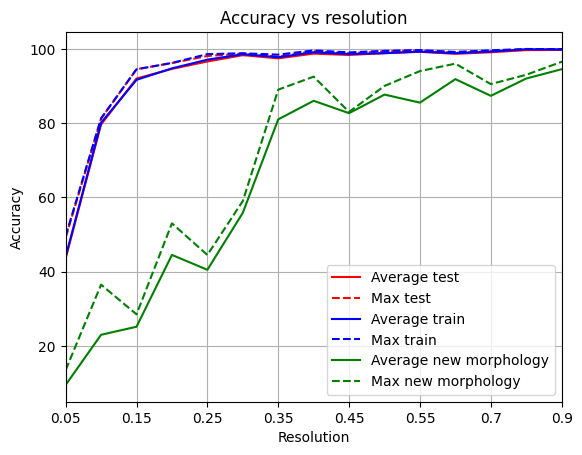

In [42]:
average_test=np.average(scores_test,axis=1)*100
max_test=np.max(scores_test,axis=1)*100
average_train=np.average(scores_train,axis=1)*100
max_train=np.max(scores_train,axis=1)*100
average_NM=np.average(scores_test_NM,axis=1)*100
max_NM=np.max(scores_test_NM,axis=1)*100


plt.plot(average_test,c="r",label="Average test")
plt.plot(max_test,"--",c="r",label="Max test")
plt.ylabel("Accuracy")
plt.plot(average_train,c="b",label="Average train")
plt.plot(max_train,"--",c="b",label="Max train")
plt.title("Accuracy vs resolution")
plt.plot(average_NM,c="g",label="Average new morphology")
plt.plot(max_NM,"--",c="g",label="Max new morphology")
plt.grid(True)
plt.xlim([0,0.7])
plt.xticks([i for i in range(0,len(resolutions),2)],labels=[resolutions[i] for i in range(0,len(resolutions),2)])
plt.xlabel("Resolution")
plt.legend(loc="lower right")
plt.savefig(path+"/images/NM_resolution_uber.pdf")
plt.show()

### LSTM train

In [13]:
torch.cuda.empty_cache()
train_loader,test_loader,unique=genLSTMData(0,4)
model,history=runLSTM(train_loader,0,4)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodel_lstm_nm")

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])


/tmp/ipykernel_30068/1139889485.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [180/180], Loss: 485.6938
Epoch [11/100], Step [180/180], Loss: 277.6262
Epoch [21/100], Step [180/180], Loss: 121.6667
Epoch [31/100], Step [180/180], Loss: 56.7687
Epoch [41/100], Step [180/180], Loss: 30.0197
Epoch [51/100], Step [180/180], Loss: 18.4568
Epoch [61/100], Step [180/180], Loss: 12.6959
Epoch [71/100], Step [180/180], Loss: 9.3566
Epoch [81/100], Step [180/180], Loss: 7.2272
Epoch [91/100], Step [180/180], Loss: 5.8434
Finished Training
Accuracy: 99.88333981445476 %
0.9988333981445475
Accuracy: 99.9708296870442 %
0.999708296870442


In [ ]:
#CNN
torch.cuda.empty_cache()
train_loader,test_loader,unique=genCNNLSTMData(0,4)

In [53]:
train_loader,test_loader,unique=genCNNLSTMData(0,4)
model,history=runLSTMcnn(train_loader,0,4,num_epochs=120)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_lstmCNN")


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 25800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.27 GB
Memory left 12.0 GB
Using 10.15 GB
torch.Size([25799, 1, 4, 110, 120])
torch.Size([25799, 15])


C:\Users\dexte\AppData\Local\Temp\ipykernel_13128\3960679742.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/120], Step [516/516], Loss: 1252.3793
Epoch [11/120], Step [516/516], Loss: 50.8115
Epoch [21/120], Step [516/516], Loss: 28.7570
Epoch [31/120], Step [516/516], Loss: 21.7160
Epoch [41/120], Step [516/516], Loss: 18.2610
Epoch [51/120], Step [516/516], Loss: 14.2798
Epoch [61/120], Step [516/516], Loss: 11.0768
Epoch [71/120], Step [516/516], Loss: 6.9041
Epoch [81/120], Step [516/516], Loss: 5.1442
Epoch [91/120], Step [516/516], Loss: 3.5459
Epoch [101/120], Step [516/516], Loss: 3.0974
Epoch [111/120], Step [516/516], Loss: 2.0778
Finished Training
Accuracy: 99.92054417550047 %
0.9992054417550047
Accuracy: 99.99951548274876 %
0.9999951548274877


In [21]:
torch.save(model.state_dict(), path+"/model/mymodel_lstm_cnn")
print(calc(model,test_loader))
print(calc(model,train_loader))

Accuracy: 98.43897561246598 %
0.9843897561246598
Accuracy: 98.73456404272756 %
0.9873456404272756


### Look at resolution

In [6]:
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
test_scores=np.zeros((len(resolutions),5))
train_scores=np.zeros((len(resolutions),5))
for i,res in enumerate(resolutions):
    print("RESOLUTIONS",i,"/",len(resolutions))
    for trial in range(5):
        train_loader,test_loader=genDataANN(0,4,res)
        model,history=runANN(train_loader,0,4)
        test_scores[i][trial]=calc(model,test_loader)
        train_scores[i][trial]=calc(model,train_loader)
        del train_loader
        del model
    np.save(path+"/saves/ANNresolutions_train",train_scores)
    np.save(path+"/saves/ANNresolutions_test",test_scores)


RESOLUTIONS 0 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.01 GB
torch.Size([6300, 120])
torch.Size([6300, 15])
SHAPE.... torch.Size([120])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 341.1466
Epoch [11/100], Step [126/126], Loss: 338.6042
Epoch [21/100], Step [126/126], Loss: 334.0971
Epoch [31/100], Step [126/126], Loss: 321.1085
Epoch [41/100], Step [126/126], Loss: 285.8190
Epoch [51/100], Step [126/126], Loss: 253.6614
Epoch [61/100], Step [126/126], Loss: 235.2817
Epoch [71/100], Step [126/126], Loss: 223.3341
Epoch [81/100], Step [126/126], Loss: 215.1157
Epoch [91/100], Step [126/126], Loss: 207.3001
Finished Training
Accuracy: 45.31386397904929 %
Accuracy: 47.73714807245887 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.01 GB
torch.Size([6300, 120])
torch.Size([6300, 15])
SHAPE.... torch.Size([120])
Epoch [1/100], Step [126/126], Loss: 341.0389


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/100], Step [126/126], Loss: 338.5871
Epoch [21/100], Step [126/126], Loss: 334.2465
Epoch [31/100], Step [126/126], Loss: 321.7248
Epoch [41/100], Step [126/126], Loss: 286.5064
Epoch [51/100], Step [126/126], Loss: 252.3686
Epoch [61/100], Step [126/126], Loss: 233.5807
Epoch [71/100], Step [126/126], Loss: 222.3630
Epoch [81/100], Step [126/126], Loss: 214.8810
Epoch [91/100], Step [126/126], Loss: 207.8597
Finished Training
Accuracy: 53.48781842710897 %
Accuracy: 57.20124600702366 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.01 GB
torch.Size([6300, 120])
torch.Size([6300, 15])
SHAPE.... torch.Size([120])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 341.0840
Epoch [11/100], Step [126/126], Loss: 338.5070
Epoch [21/100], Step [126/126], Loss: 333.9768
Epoch [31/100], Step [126/126], Loss: 320.8472
Epoch [41/100], Step [126/126], Loss: 286.3811
Epoch [51/100], Step [126/126], Loss: 252.8347
Epoch [61/100], Step [126/126], Loss: 233.6729
Epoch [71/100], Step [126/126], Loss: 222.1309
Epoch [81/100], Step [126/126], Loss: 213.9848
Epoch [91/100], Step [126/126], Loss: 205.8698
Finished Training
Accuracy: 49.123085469407194 %
Accuracy: 51.68548243090415 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.01 GB
torch.Size([6300, 120])
torch.Size([6300, 15])
SHAPE.... torch.Size([120])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 341.2213
Epoch [11/100], Step [126/126], Loss: 338.6456
Epoch [21/100], Step [126/126], Loss: 334.4300
Epoch [31/100], Step [126/126], Loss: 322.2496
Epoch [41/100], Step [126/126], Loss: 288.1193
Epoch [51/100], Step [126/126], Loss: 252.1097
Epoch [61/100], Step [126/126], Loss: 232.1926
Epoch [71/100], Step [126/126], Loss: 220.9174
Epoch [81/100], Step [126/126], Loss: 213.0723
Epoch [91/100], Step [126/126], Loss: 205.2348
Finished Training
Accuracy: 48.25013887786684 %
Accuracy: 52.22118608757762 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (5, 6)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.01 GB
torch.Size([6300, 120])
torch.Size([6300, 15])
SHAPE.... torch.Size([120])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.9933
Epoch [11/100], Step [126/126], Loss: 338.2186
Epoch [21/100], Step [126/126], Loss: 332.9700
Epoch [31/100], Step [126/126], Loss: 317.2710
Epoch [41/100], Step [126/126], Loss: 278.8536
Epoch [51/100], Step [126/126], Loss: 247.7726
Epoch [61/100], Step [126/126], Loss: 229.6701
Epoch [71/100], Step [126/126], Loss: 218.8324
Epoch [81/100], Step [126/126], Loss: 210.7981
Epoch [91/100], Step [126/126], Loss: 202.5852
Finished Training
Accuracy: 54.59884136179669 %
Accuracy: 55.73302117021487 %
RESOLUTIONS 1 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.02 GB
torch.Size([6300, 528])
torch.Size([6300, 15])
SHAPE.... torch.Size([528])
Epoch [1/100], Step [126/126], Loss: 341.1247


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/100], Step [126/126], Loss: 333.8863
Epoch [21/100], Step [126/126], Loss: 295.8509
Epoch [31/100], Step [126/126], Loss: 236.7594
Epoch [41/100], Step [126/126], Loss: 210.7637
Epoch [51/100], Step [126/126], Loss: 199.1170
Epoch [61/100], Step [126/126], Loss: 187.7593
Epoch [71/100], Step [126/126], Loss: 174.3140
Epoch [81/100], Step [126/126], Loss: 157.6535
Epoch [91/100], Step [126/126], Loss: 139.8682
Finished Training
Accuracy: 70.47059757162131 %
Accuracy: 68.98672645384019 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.02 GB
torch.Size([6300, 528])
torch.Size([6300, 15])
SHAPE.... torch.Size([528])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.8607
Epoch [11/100], Step [126/126], Loss: 331.3224
Epoch [21/100], Step [126/126], Loss: 281.6093
Epoch [31/100], Step [126/126], Loss: 232.1118
Epoch [41/100], Step [126/126], Loss: 209.5098
Epoch [51/100], Step [126/126], Loss: 196.9011
Epoch [61/100], Step [126/126], Loss: 183.7564
Epoch [71/100], Step [126/126], Loss: 168.0930
Epoch [81/100], Step [126/126], Loss: 150.1431
Epoch [91/100], Step [126/126], Loss: 132.9936
Finished Training
Accuracy: 70.39123879057219 %
Accuracy: 71.22874546139957 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.02 GB
torch.Size([6300, 528])
torch.Size([6300, 15])
SHAPE.... torch.Size([528])
Epoch [1/100], Step [126/126], Loss: 340.9542


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/100], Step [126/126], Loss: 331.8397
Epoch [21/100], Step [126/126], Loss: 288.6684
Epoch [31/100], Step [126/126], Loss: 237.3716
Epoch [41/100], Step [126/126], Loss: 211.9099
Epoch [51/100], Step [126/126], Loss: 198.7427
Epoch [61/100], Step [126/126], Loss: 185.8570
Epoch [71/100], Step [126/126], Loss: 170.2460
Epoch [81/100], Step [126/126], Loss: 151.5233
Epoch [91/100], Step [126/126], Loss: 134.0240
Finished Training
Accuracy: 71.58162050630904 %
Accuracy: 73.29219658340111 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.02 GB
torch.Size([6300, 528])
torch.Size([6300, 15])
SHAPE.... torch.Size([528])
Epoch [1/100], Step [126/126], Loss: 341.1479


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [11/100], Step [126/126], Loss: 332.9716
Epoch [21/100], Step [126/126], Loss: 290.6381
Epoch [31/100], Step [126/126], Loss: 233.5581
Epoch [41/100], Step [126/126], Loss: 210.8392
Epoch [51/100], Step [126/126], Loss: 199.4682
Epoch [61/100], Step [126/126], Loss: 187.5327
Epoch [71/100], Step [126/126], Loss: 172.8958
Epoch [81/100], Step [126/126], Loss: 154.9445
Epoch [91/100], Step [126/126], Loss: 136.9597
Finished Training
Accuracy: 71.66097928735815 %
Accuracy: 74.70089879169063 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (11, 12)
Memory needed: 0.0 GB
Memory left 1.93 GB
Using 0.02 GB
torch.Size([6300, 528])
torch.Size([6300, 15])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


SHAPE.... torch.Size([528])
Epoch [1/100], Step [126/126], Loss: 340.8111
Epoch [11/100], Step [126/126], Loss: 332.8133
Epoch [21/100], Step [126/126], Loss: 290.2284
Epoch [31/100], Step [126/126], Loss: 232.3197
Epoch [41/100], Step [126/126], Loss: 209.9665
Epoch [51/100], Step [126/126], Loss: 198.9693
Epoch [61/100], Step [126/126], Loss: 186.4598
Epoch [71/100], Step [126/126], Loss: 170.7626
Epoch [81/100], Step [126/126], Loss: 152.4371
Epoch [91/100], Step [126/126], Loss: 135.0022
Finished Training
Accuracy: 76.02571224505992 %
Accuracy: 79.48254994940575 %
RESOLUTIONS 2 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 1.93 GB
Using 0.05 GB
torch.Size([6300, 1152])
torch.Size([6300, 15])
SHAPE.... torch.Size([1152])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 341.0310
Epoch [11/100], Step [126/126], Loss: 328.8463
Epoch [21/100], Step [126/126], Loss: 255.7941
Epoch [31/100], Step [126/126], Loss: 210.6310
Epoch [41/100], Step [126/126], Loss: 195.2658
Epoch [51/100], Step [126/126], Loss: 176.9037
Epoch [61/100], Step [126/126], Loss: 151.8534
Epoch [71/100], Step [126/126], Loss: 129.3696
Epoch [81/100], Step [126/126], Loss: 112.5140
Epoch [91/100], Step [126/126], Loss: 98.7656
Finished Training
Accuracy: 77.93032299023888 %
Accuracy: 79.89920834904069 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 1.93 GB
Using 0.05 GB
torch.Size([6300, 1152])
torch.Size([6300, 15])
SHAPE.... torch.Size([1152])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.9244
Epoch [11/100], Step [126/126], Loss: 329.7362
Epoch [21/100], Step [126/126], Loss: 257.7466
Epoch [31/100], Step [126/126], Loss: 210.8266
Epoch [41/100], Step [126/126], Loss: 195.7094
Epoch [51/100], Step [126/126], Loss: 177.6529
Epoch [61/100], Step [126/126], Loss: 152.7635
Epoch [71/100], Step [126/126], Loss: 130.5423
Epoch [81/100], Step [126/126], Loss: 114.5015
Epoch [91/100], Step [126/126], Loss: 101.5937
Finished Training
Accuracy: 81.18403301325291 %
Accuracy: 82.75629451796591 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 1.93 GB
Using 0.05 GB
torch.Size([6300, 1152])
torch.Size([6300, 15])
SHAPE.... torch.Size([1152])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.9268
Epoch [11/100], Step [126/126], Loss: 325.8074
Epoch [21/100], Step [126/126], Loss: 250.9994
Epoch [31/100], Step [126/126], Loss: 210.5497
Epoch [41/100], Step [126/126], Loss: 195.8478
Epoch [51/100], Step [126/126], Loss: 176.4423
Epoch [61/100], Step [126/126], Loss: 149.7989
Epoch [71/100], Step [126/126], Loss: 128.3464
Epoch [81/100], Step [126/126], Loss: 112.9272
Epoch [91/100], Step [126/126], Loss: 100.8803
Finished Training
Accuracy: 74.43853662407746 %
Accuracy: 77.14132656098093 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 1.93 GB
Using 0.05 GB
torch.Size([6300, 1152])
torch.Size([6300, 15])
SHAPE.... torch.Size([1152])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 341.1127
Epoch [11/100], Step [126/126], Loss: 327.1022
Epoch [21/100], Step [126/126], Loss: 252.1400
Epoch [31/100], Step [126/126], Loss: 212.4388
Epoch [41/100], Step [126/126], Loss: 199.8263
Epoch [51/100], Step [126/126], Loss: 184.9851
Epoch [61/100], Step [126/126], Loss: 161.9861
Epoch [71/100], Step [126/126], Loss: 137.3216
Epoch [81/100], Step [126/126], Loss: 118.7739
Epoch [91/100], Step [126/126], Loss: 104.2780
Finished Training
Accuracy: 77.93032299023888 %
Accuracy: 81.03013829090692 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (16, 18)
Memory needed: 0.01 GB
Memory left 1.93 GB
Using 0.05 GB
torch.Size([6300, 1152])
torch.Size([6300, 15])
SHAPE.... torch.Size([1152])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.7438
Epoch [11/100], Step [126/126], Loss: 327.4011
Epoch [21/100], Step [126/126], Loss: 248.6986
Epoch [31/100], Step [126/126], Loss: 208.9611
Epoch [41/100], Step [126/126], Loss: 193.2462
Epoch [51/100], Step [126/126], Loss: 170.0832
Epoch [61/100], Step [126/126], Loss: 142.8261
Epoch [71/100], Step [126/126], Loss: 123.0594
Epoch [81/100], Step [126/126], Loss: 108.8521
Epoch [91/100], Step [126/126], Loss: 97.3699
Finished Training
Accuracy: 78.3271168954845 %
Accuracy: 78.98652804507846 %
RESOLUTIONS 3 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 1.93 GB
Using 0.1 GB
torch.Size([6300, 2112])
torch.Size([6300, 15])
SHAPE.... torch.Size([2112])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.8010
Epoch [11/100], Step [126/126], Loss: 310.7768
Epoch [21/100], Step [126/126], Loss: 219.7316
Epoch [31/100], Step [126/126], Loss: 197.3813
Epoch [41/100], Step [126/126], Loss: 176.2181
Epoch [51/100], Step [126/126], Loss: 146.7632
Epoch [61/100], Step [126/126], Loss: 123.4212
Epoch [71/100], Step [126/126], Loss: 104.7770
Epoch [81/100], Step [126/126], Loss: 86.1468
Epoch [91/100], Step [126/126], Loss: 66.2212
Finished Training
Accuracy: 93.24656773271963 %
Accuracy: 94.4227297077439 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 1.93 GB
Using 0.1 GB
torch.Size([6300, 2112])
torch.Size([6300, 15])
SHAPE.... torch.Size([2112])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.6390
Epoch [11/100], Step [126/126], Loss: 306.9383
Epoch [21/100], Step [126/126], Loss: 218.8751
Epoch [31/100], Step [126/126], Loss: 197.8407
Epoch [41/100], Step [126/126], Loss: 177.6982
Epoch [51/100], Step [126/126], Loss: 149.4316
Epoch [61/100], Step [126/126], Loss: 124.5381
Epoch [71/100], Step [126/126], Loss: 104.0221
Epoch [81/100], Step [126/126], Loss: 83.3517
Epoch [91/100], Step [126/126], Loss: 62.7987
Finished Training
Accuracy: 93.0878501706214 %
Accuracy: 93.94654867958968 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 1.93 GB
Using 0.1 GB
torch.Size([6300, 2112])
torch.Size([6300, 15])
SHAPE.... torch.Size([2112])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.5834
Epoch [11/100], Step [126/126], Loss: 308.5912
Epoch [21/100], Step [126/126], Loss: 222.4491
Epoch [31/100], Step [126/126], Loss: 198.5147
Epoch [41/100], Step [126/126], Loss: 178.7490
Epoch [51/100], Step [126/126], Loss: 150.1489
Epoch [61/100], Step [126/126], Loss: 124.4235
Epoch [71/100], Step [126/126], Loss: 102.9776
Epoch [81/100], Step [126/126], Loss: 81.7709
Epoch [91/100], Step [126/126], Loss: 61.3421
Finished Training
Accuracy: 94.43694944845647 %
Accuracy: 94.66082022182098 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 1.93 GB
Using 0.1 GB
torch.Size([6300, 2112])
torch.Size([6300, 15])
SHAPE.... torch.Size([2112])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.6747
Epoch [11/100], Step [126/126], Loss: 309.4027
Epoch [21/100], Step [126/126], Loss: 217.7101
Epoch [31/100], Step [126/126], Loss: 196.8901
Epoch [41/100], Step [126/126], Loss: 177.5000
Epoch [51/100], Step [126/126], Loss: 150.2133
Epoch [61/100], Step [126/126], Loss: 125.5810
Epoch [71/100], Step [126/126], Loss: 105.6897
Epoch [81/100], Step [126/126], Loss: 85.1718
Epoch [91/100], Step [126/126], Loss: 64.6001
Finished Training
Accuracy: 91.97682723593367 %
Accuracy: 92.87514136624273 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (22, 24)
Memory needed: 0.02 GB
Memory left 1.93 GB
Using 0.1 GB
torch.Size([6300, 2112])
torch.Size([6300, 15])
SHAPE.... torch.Size([2112])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.5460
Epoch [11/100], Step [126/126], Loss: 306.5015
Epoch [21/100], Step [126/126], Loss: 221.5180
Epoch [31/100], Step [126/126], Loss: 199.2706
Epoch [41/100], Step [126/126], Loss: 180.4100
Epoch [51/100], Step [126/126], Loss: 152.6674
Epoch [61/100], Step [126/126], Loss: 127.3170
Epoch [71/100], Step [126/126], Loss: 108.1977
Epoch [81/100], Step [126/126], Loss: 90.3512
Epoch [91/100], Step [126/126], Loss: 71.8508
Finished Training
Accuracy: 92.13554479803192 %
Accuracy: 92.33943770956925 %
RESOLUTIONS 4 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (27, 30)
Memory needed: 0.03 GB
Memory left 1.93 GB
Using 0.15 GB
torch.Size([6300, 3240])
torch.Size([6300, 15])
SHAPE.... torch.Size([3240])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.3434
Epoch [11/100], Step [126/126], Loss: 280.4226
Epoch [21/100], Step [126/126], Loss: 206.3373
Epoch [31/100], Step [126/126], Loss: 186.8268
Epoch [41/100], Step [126/126], Loss: 151.9611
Epoch [51/100], Step [126/126], Loss: 121.1807
Epoch [61/100], Step [126/126], Loss: 97.9475
Epoch [71/100], Step [126/126], Loss: 73.2542
Epoch [81/100], Step [126/126], Loss: 50.4429
Epoch [91/100], Step [126/126], Loss: 35.3192
Finished Training
Accuracy: 95.5479723831442 %
Accuracy: 95.11716037380211 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (27, 30)
Memory needed: 0.03 GB
Memory left 1.93 GB
Using 0.15 GB
torch.Size([6300, 3240])
torch.Size([6300, 15])
SHAPE.... torch.Size([3240])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.3588
Epoch [11/100], Step [126/126], Loss: 278.1727
Epoch [21/100], Step [126/126], Loss: 204.6311
Epoch [31/100], Step [126/126], Loss: 185.8320
Epoch [41/100], Step [126/126], Loss: 153.4262
Epoch [51/100], Step [126/126], Loss: 120.5718
Epoch [61/100], Step [126/126], Loss: 93.0014
Epoch [71/100], Step [126/126], Loss: 65.3284
Epoch [81/100], Step [126/126], Loss: 44.8334
Epoch [91/100], Step [126/126], Loss: 32.3587
Finished Training
Accuracy: 94.43694944845647 %
Accuracy: 94.68066109799408 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (27, 30)
Memory needed: 0.03 GB
Memory left 1.93 GB
Using 0.15 GB
torch.Size([6300, 3240])
torch.Size([6300, 15])
SHAPE.... torch.Size([3240])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.5136
Epoch [11/100], Step [126/126], Loss: 291.6020
Epoch [21/100], Step [126/126], Loss: 207.4273
Epoch [31/100], Step [126/126], Loss: 184.7291
Epoch [41/100], Step [126/126], Loss: 147.7029
Epoch [51/100], Step [126/126], Loss: 111.9482
Epoch [61/100], Step [126/126], Loss: 80.5349
Epoch [71/100], Step [126/126], Loss: 54.6416
Epoch [81/100], Step [126/126], Loss: 38.0966
Epoch [91/100], Step [126/126], Loss: 28.6383
Finished Training
Accuracy: 95.2305372589477 %
Accuracy: 95.87111366837959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (27, 30)
Memory needed: 0.03 GB
Memory left 1.93 GB
Using 0.15 GB
torch.Size([6300, 3240])
torch.Size([6300, 15])
SHAPE.... torch.Size([3240])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.3848
Epoch [11/100], Step [126/126], Loss: 282.6995
Epoch [21/100], Step [126/126], Loss: 204.6741
Epoch [31/100], Step [126/126], Loss: 180.8195
Epoch [41/100], Step [126/126], Loss: 144.5297
Epoch [51/100], Step [126/126], Loss: 110.9652
Epoch [61/100], Step [126/126], Loss: 79.6503
Epoch [71/100], Step [126/126], Loss: 53.9746
Epoch [81/100], Step [126/126], Loss: 37.6715
Epoch [91/100], Step [126/126], Loss: 28.3775
Finished Training
Accuracy: 95.30989603999683 %
Accuracy: 95.89095454455267 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (27, 30)
Memory needed: 0.03 GB
Memory left 1.93 GB
Using 0.15 GB
torch.Size([6300, 3240])
torch.Size([6300, 15])
SHAPE.... torch.Size([3240])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.5150
Epoch [11/100], Step [126/126], Loss: 279.0994
Epoch [21/100], Step [126/126], Loss: 204.8156
Epoch [31/100], Step [126/126], Loss: 181.3879
Epoch [41/100], Step [126/126], Loss: 145.1785
Epoch [51/100], Step [126/126], Loss: 115.5413
Epoch [61/100], Step [126/126], Loss: 89.6861
Epoch [71/100], Step [126/126], Loss: 62.5895
Epoch [81/100], Step [126/126], Loss: 42.5424
Epoch [91/100], Step [126/126], Loss: 31.1220
Finished Training
Accuracy: 95.86540750734069 %
Accuracy: 95.47429614491774 %
RESOLUTIONS 5 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (33, 36)
Memory needed: 0.04 GB
Memory left 1.93 GB
Using 0.22 GB
torch.Size([6300, 4752])
torch.Size([6300, 15])
SHAPE.... torch.Size([4752])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.1087
Epoch [11/100], Step [126/126], Loss: 251.4088
Epoch [21/100], Step [126/126], Loss: 196.9828
Epoch [31/100], Step [126/126], Loss: 166.8260
Epoch [41/100], Step [126/126], Loss: 122.2608
Epoch [51/100], Step [126/126], Loss: 83.9023
Epoch [61/100], Step [126/126], Loss: 54.6074
Epoch [71/100], Step [126/126], Loss: 36.6548
Epoch [81/100], Step [126/126], Loss: 25.9419
Epoch [91/100], Step [126/126], Loss: 18.8673
Finished Training
Accuracy: 99.19847631140387 %
Accuracy: 99.28374437015138 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (33, 36)
Memory needed: 0.04 GB
Memory left 1.93 GB
Using 0.22 GB
torch.Size([6300, 4752])
torch.Size([6300, 15])
SHAPE.... torch.Size([4752])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.9127
Epoch [11/100], Step [126/126], Loss: 249.7662
Epoch [21/100], Step [126/126], Loss: 197.8057
Epoch [31/100], Step [126/126], Loss: 167.6703
Epoch [41/100], Step [126/126], Loss: 119.6108
Epoch [51/100], Step [126/126], Loss: 76.9991
Epoch [61/100], Step [126/126], Loss: 48.2581
Epoch [71/100], Step [126/126], Loss: 32.6999
Epoch [81/100], Step [126/126], Loss: 24.2664
Epoch [91/100], Step [126/126], Loss: 19.1569
Finished Training
Accuracy: 97.05578922307754 %
Accuracy: 97.59726989543857 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (33, 36)
Memory needed: 0.04 GB
Memory left 1.93 GB
Using 0.22 GB
torch.Size([6300, 4752])
torch.Size([6300, 15])
SHAPE.... torch.Size([4752])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 340.0718
Epoch [11/100], Step [126/126], Loss: 257.5017
Epoch [21/100], Step [126/126], Loss: 201.3378
Epoch [31/100], Step [126/126], Loss: 175.2255
Epoch [41/100], Step [126/126], Loss: 128.0453
Epoch [51/100], Step [126/126], Loss: 86.3050
Epoch [61/100], Step [126/126], Loss: 55.3737
Epoch [71/100], Step [126/126], Loss: 36.8040
Epoch [81/100], Step [126/126], Loss: 26.3997
Epoch [91/100], Step [126/126], Loss: 19.7495
Finished Training
Accuracy: 98.88104118720737 %
Accuracy: 98.96629035138191 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (33, 36)
Memory needed: 0.04 GB
Memory left 1.93 GB
Using 0.22 GB
torch.Size([6300, 4752])
torch.Size([6300, 15])
SHAPE.... torch.Size([4752])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.8892
Epoch [11/100], Step [126/126], Loss: 251.8812
Epoch [21/100], Step [126/126], Loss: 197.2969
Epoch [31/100], Step [126/126], Loss: 169.2443
Epoch [41/100], Step [126/126], Loss: 125.3994
Epoch [51/100], Step [126/126], Loss: 85.4782
Epoch [61/100], Step [126/126], Loss: 54.2443
Epoch [71/100], Step [126/126], Loss: 35.8341
Epoch [81/100], Step [126/126], Loss: 25.8172
Epoch [91/100], Step [126/126], Loss: 19.3514
Finished Training
Accuracy: 97.9287358146179 %
Accuracy: 98.66867720878554 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (33, 36)
Memory needed: 0.04 GB
Memory left 1.93 GB
Using 0.22 GB
torch.Size([6300, 4752])
torch.Size([6300, 15])
SHAPE.... torch.Size([4752])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.9963
Epoch [11/100], Step [126/126], Loss: 252.0085
Epoch [21/100], Step [126/126], Loss: 198.4081
Epoch [31/100], Step [126/126], Loss: 168.8751
Epoch [41/100], Step [126/126], Loss: 121.8170
Epoch [51/100], Step [126/126], Loss: 80.4144
Epoch [61/100], Step [126/126], Loss: 50.8693
Epoch [71/100], Step [126/126], Loss: 34.2923
Epoch [81/100], Step [126/126], Loss: 24.7690
Epoch [91/100], Step [126/126], Loss: 18.4333
Finished Training
Accuracy: 98.48424728196176 %
Accuracy: 99.04565385607428 %
RESOLUTIONS 6 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 1.93 GB
Using 0.3 GB
torch.Size([6300, 6384])
torch.Size([6300, 15])
SHAPE.... torch.Size([6384])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.5213
Epoch [11/100], Step [126/126], Loss: 227.1098
Epoch [21/100], Step [126/126], Loss: 186.5392
Epoch [31/100], Step [126/126], Loss: 135.9433
Epoch [41/100], Step [126/126], Loss: 87.3430
Epoch [51/100], Step [126/126], Loss: 52.6370
Epoch [61/100], Step [126/126], Loss: 33.6636
Epoch [71/100], Step [126/126], Loss: 23.7124
Epoch [81/100], Step [126/126], Loss: 17.1718
Epoch [91/100], Step [126/126], Loss: 12.1483
Finished Training
Accuracy: 99.51591143560036 %
Accuracy: 99.74008452213249 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 1.93 GB
Using 0.3 GB
torch.Size([6300, 6384])
torch.Size([6300, 15])
SHAPE.... torch.Size([6384])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.6927
Epoch [11/100], Step [126/126], Loss: 227.9426
Epoch [21/100], Step [126/126], Loss: 189.3908
Epoch [31/100], Step [126/126], Loss: 142.2306
Epoch [41/100], Step [126/126], Loss: 89.3519
Epoch [51/100], Step [126/126], Loss: 52.9595
Epoch [61/100], Step [126/126], Loss: 33.1223
Epoch [71/100], Step [126/126], Loss: 22.5234
Epoch [81/100], Step [126/126], Loss: 15.8722
Epoch [91/100], Step [126/126], Loss: 11.2093
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.74008452213249 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 1.93 GB
Using 0.3 GB
torch.Size([6300, 6384])
torch.Size([6300, 15])
SHAPE.... torch.Size([6384])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.9346
Epoch [11/100], Step [126/126], Loss: 228.6988
Epoch [21/100], Step [126/126], Loss: 189.0689
Epoch [31/100], Step [126/126], Loss: 140.7566
Epoch [41/100], Step [126/126], Loss: 86.0844
Epoch [51/100], Step [126/126], Loss: 51.7026
Epoch [61/100], Step [126/126], Loss: 33.3648
Epoch [71/100], Step [126/126], Loss: 23.2245
Epoch [81/100], Step [126/126], Loss: 16.8821
Epoch [91/100], Step [126/126], Loss: 12.2886
Finished Training
Accuracy: 99.03975874930562 %
Accuracy: 99.34326699867066 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 1.93 GB
Using 0.3 GB
torch.Size([6300, 6384])
torch.Size([6300, 15])
SHAPE.... torch.Size([6384])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.7793
Epoch [11/100], Step [126/126], Loss: 227.4737
Epoch [21/100], Step [126/126], Loss: 185.9913
Epoch [31/100], Step [126/126], Loss: 137.1958
Epoch [41/100], Step [126/126], Loss: 91.9394
Epoch [51/100], Step [126/126], Loss: 54.9753
Epoch [61/100], Step [126/126], Loss: 34.3033
Epoch [71/100], Step [126/126], Loss: 23.3793
Epoch [81/100], Step [126/126], Loss: 16.6952
Epoch [91/100], Step [126/126], Loss: 11.8107
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.81944802682486 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (38, 42)
Memory needed: 0.05 GB
Memory left 1.93 GB
Using 0.3 GB
torch.Size([6300, 6384])
torch.Size([6300, 15])
SHAPE.... torch.Size([6384])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.5149
Epoch [11/100], Step [126/126], Loss: 227.0117
Epoch [21/100], Step [126/126], Loss: 186.2319
Epoch [31/100], Step [126/126], Loss: 136.4974
Epoch [41/100], Step [126/126], Loss: 88.0494
Epoch [51/100], Step [126/126], Loss: 52.1960
Epoch [61/100], Step [126/126], Loss: 32.8454
Epoch [71/100], Step [126/126], Loss: 23.0315
Epoch [81/100], Step [126/126], Loss: 17.1655
Epoch [91/100], Step [126/126], Loss: 12.6297
Finished Training
Accuracy: 99.75398777874773 %
Accuracy: 99.7202436459594 %
RESOLUTIONS 7 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (44, 48)
Memory needed: 0.07 GB
Memory left 1.93 GB
Using 0.4 GB
torch.Size([6300, 8448])
torch.Size([6300, 15])
SHAPE.... torch.Size([8448])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.0924
Epoch [11/100], Step [126/126], Loss: 208.9582
Epoch [21/100], Step [126/126], Loss: 168.7331
Epoch [31/100], Step [126/126], Loss: 105.3595
Epoch [41/100], Step [126/126], Loss: 57.1026
Epoch [51/100], Step [126/126], Loss: 32.6489
Epoch [61/100], Step [126/126], Loss: 20.1325
Epoch [71/100], Step [126/126], Loss: 12.2577
Epoch [81/100], Step [126/126], Loss: 7.7130
Epoch [91/100], Step [126/126], Loss: 5.2983
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.91865240769032 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (44, 48)
Memory needed: 0.07 GB
Memory left 1.93 GB
Using 0.4 GB
torch.Size([6300, 8448])
torch.Size([6300, 15])
SHAPE.... torch.Size([8448])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.8222
Epoch [11/100], Step [126/126], Loss: 209.5226
Epoch [21/100], Step [126/126], Loss: 170.3378
Epoch [31/100], Step [126/126], Loss: 104.1263
Epoch [41/100], Step [126/126], Loss: 55.7508
Epoch [51/100], Step [126/126], Loss: 31.7043
Epoch [61/100], Step [126/126], Loss: 19.3055
Epoch [71/100], Step [126/126], Loss: 11.8257
Epoch [81/100], Step [126/126], Loss: 7.5837
Epoch [91/100], Step [126/126], Loss: 5.2766
Finished Training
Accuracy: 99.75398777874773 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (44, 48)
Memory needed: 0.07 GB
Memory left 1.93 GB
Using 0.4 GB
torch.Size([6300, 8448])
torch.Size([6300, 15])
SHAPE.... torch.Size([8448])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.8420
Epoch [11/100], Step [126/126], Loss: 210.1137
Epoch [21/100], Step [126/126], Loss: 171.1132
Epoch [31/100], Step [126/126], Loss: 102.6501
Epoch [41/100], Step [126/126], Loss: 54.9633
Epoch [51/100], Step [126/126], Loss: 32.2623
Epoch [61/100], Step [126/126], Loss: 20.0899
Epoch [71/100], Step [126/126], Loss: 12.6240
Epoch [81/100], Step [126/126], Loss: 8.1278
Epoch [91/100], Step [126/126], Loss: 5.5702
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.93849328386341 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (44, 48)
Memory needed: 0.07 GB
Memory left 1.93 GB
Using 0.4 GB
torch.Size([6300, 8448])
torch.Size([6300, 15])
SHAPE.... torch.Size([8448])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.1319
Epoch [11/100], Step [126/126], Loss: 211.8581
Epoch [21/100], Step [126/126], Loss: 173.8619
Epoch [31/100], Step [126/126], Loss: 103.4849
Epoch [41/100], Step [126/126], Loss: 53.4312
Epoch [51/100], Step [126/126], Loss: 30.0496
Epoch [61/100], Step [126/126], Loss: 18.3189
Epoch [71/100], Step [126/126], Loss: 11.3390
Epoch [81/100], Step [126/126], Loss: 7.3940
Epoch [91/100], Step [126/126], Loss: 5.2393
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (44, 48)
Memory needed: 0.07 GB
Memory left 1.93 GB
Using 0.4 GB
torch.Size([6300, 8448])
torch.Size([6300, 15])
SHAPE.... torch.Size([8448])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.9359
Epoch [11/100], Step [126/126], Loss: 209.2957
Epoch [21/100], Step [126/126], Loss: 164.9053
Epoch [31/100], Step [126/126], Loss: 92.3403
Epoch [41/100], Step [126/126], Loss: 48.5148
Epoch [51/100], Step [126/126], Loss: 27.9765
Epoch [61/100], Step [126/126], Loss: 17.2876
Epoch [71/100], Step [126/126], Loss: 10.7884
Epoch [81/100], Step [126/126], Loss: 7.0816
Epoch [91/100], Step [126/126], Loss: 5.0948
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.93849328386341 %
RESOLUTIONS 8 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (49, 54)
Memory needed: 0.09 GB
Memory left 1.93 GB
Using 0.5 GB
torch.Size([6300, 10584])
torch.Size([6300, 15])
SHAPE.... torch.Size([10584])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.4174
Epoch [11/100], Step [126/126], Loss: 198.2142
Epoch [21/100], Step [126/126], Loss: 144.2998
Epoch [31/100], Step [126/126], Loss: 72.5893
Epoch [41/100], Step [126/126], Loss: 39.0944
Epoch [51/100], Step [126/126], Loss: 23.7634
Epoch [61/100], Step [126/126], Loss: 14.9809
Epoch [71/100], Step [126/126], Loss: 9.2290
Epoch [81/100], Step [126/126], Loss: 6.0278
Epoch [91/100], Step [126/126], Loss: 4.2643
Finished Training
Accuracy: 99.83334655979685 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (49, 54)
Memory needed: 0.09 GB
Memory left 1.93 GB
Using 0.5 GB
torch.Size([6300, 10584])
torch.Size([6300, 15])
SHAPE.... torch.Size([10584])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 339.1323
Epoch [11/100], Step [126/126], Loss: 201.4348
Epoch [21/100], Step [126/126], Loss: 152.0151
Epoch [31/100], Step [126/126], Loss: 80.8511
Epoch [41/100], Step [126/126], Loss: 41.7668
Epoch [51/100], Step [126/126], Loss: 25.1592
Epoch [61/100], Step [126/126], Loss: 16.8288
Epoch [71/100], Step [126/126], Loss: 11.2317
Epoch [81/100], Step [126/126], Loss: 7.2275
Epoch [91/100], Step [126/126], Loss: 4.9439
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (49, 54)
Memory needed: 0.09 GB
Memory left 1.93 GB
Using 0.5 GB
torch.Size([6300, 10584])
torch.Size([6300, 15])
SHAPE.... torch.Size([10584])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.7155
Epoch [11/100], Step [126/126], Loss: 202.2553
Epoch [21/100], Step [126/126], Loss: 150.4553
Epoch [31/100], Step [126/126], Loss: 78.1094
Epoch [41/100], Step [126/126], Loss: 41.5668
Epoch [51/100], Step [126/126], Loss: 24.5375
Epoch [61/100], Step [126/126], Loss: 15.1184
Epoch [71/100], Step [126/126], Loss: 9.2779
Epoch [81/100], Step [126/126], Loss: 5.9939
Epoch [91/100], Step [126/126], Loss: 4.2312
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.93849328386341 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (49, 54)
Memory needed: 0.09 GB
Memory left 1.93 GB
Using 0.5 GB
torch.Size([6300, 10584])
torch.Size([6300, 15])
SHAPE.... torch.Size([10584])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.6638
Epoch [11/100], Step [126/126], Loss: 206.3247
Epoch [21/100], Step [126/126], Loss: 150.6603
Epoch [31/100], Step [126/126], Loss: 81.2443
Epoch [41/100], Step [126/126], Loss: 42.4884
Epoch [51/100], Step [126/126], Loss: 24.7304
Epoch [61/100], Step [126/126], Loss: 15.1379
Epoch [71/100], Step [126/126], Loss: 9.0380
Epoch [81/100], Step [126/126], Loss: 5.8128
Epoch [91/100], Step [126/126], Loss: 4.1306
Finished Training
Accuracy: 99.83334655979685 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (49, 54)
Memory needed: 0.09 GB
Memory left 1.93 GB
Using 0.5 GB
torch.Size([6300, 10584])
torch.Size([6300, 15])
SHAPE.... torch.Size([10584])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.7675
Epoch [11/100], Step [126/126], Loss: 202.9034
Epoch [21/100], Step [126/126], Loss: 154.9689
Epoch [31/100], Step [126/126], Loss: 78.2397
Epoch [41/100], Step [126/126], Loss: 40.5581
Epoch [51/100], Step [126/126], Loss: 23.8058
Epoch [61/100], Step [126/126], Loss: 14.7876
Epoch [71/100], Step [126/126], Loss: 9.2527
Epoch [81/100], Step [126/126], Loss: 6.1802
Epoch [91/100], Step [126/126], Loss: 4.4621
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.91865240769032 %
RESOLUTIONS 9 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (55, 60)
Memory needed: 0.11 GB
Memory left 1.93 GB
Using 0.62 GB
torch.Size([6300, 13200])
torch.Size([6300, 15])
SHAPE.... torch.Size([13200])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.3464
Epoch [11/100], Step [126/126], Loss: 191.4194
Epoch [21/100], Step [126/126], Loss: 106.5958
Epoch [31/100], Step [126/126], Loss: 47.3558
Epoch [41/100], Step [126/126], Loss: 23.8118
Epoch [51/100], Step [126/126], Loss: 12.2138
Epoch [61/100], Step [126/126], Loss: 6.9557
Epoch [71/100], Step [126/126], Loss: 4.4919
Epoch [81/100], Step [126/126], Loss: 3.2102
Epoch [91/100], Step [126/126], Loss: 2.4385
Finished Training
Accuracy: 99.83334655979685 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (55, 60)
Memory needed: 0.11 GB
Memory left 1.93 GB
Using 0.62 GB
torch.Size([6300, 13200])
torch.Size([6300, 15])
SHAPE.... torch.Size([13200])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.0550
Epoch [11/100], Step [126/126], Loss: 188.8917
Epoch [21/100], Step [126/126], Loss: 100.2443
Epoch [31/100], Step [126/126], Loss: 45.5114
Epoch [41/100], Step [126/126], Loss: 22.9207
Epoch [51/100], Step [126/126], Loss: 11.9389
Epoch [61/100], Step [126/126], Loss: 6.8928
Epoch [71/100], Step [126/126], Loss: 4.4983
Epoch [81/100], Step [126/126], Loss: 3.2336
Epoch [91/100], Step [126/126], Loss: 2.4699
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (55, 60)
Memory needed: 0.11 GB
Memory left 1.93 GB
Using 0.62 GB
torch.Size([6300, 13200])
torch.Size([6300, 15])
SHAPE.... torch.Size([13200])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.8829
Epoch [11/100], Step [126/126], Loss: 186.8382
Epoch [21/100], Step [126/126], Loss: 102.2906
Epoch [31/100], Step [126/126], Loss: 45.5704
Epoch [41/100], Step [126/126], Loss: 23.1666
Epoch [51/100], Step [126/126], Loss: 12.0304
Epoch [61/100], Step [126/126], Loss: 6.8983
Epoch [71/100], Step [126/126], Loss: 4.4564
Epoch [81/100], Step [126/126], Loss: 3.1820
Epoch [91/100], Step [126/126], Loss: 2.4093
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (55, 60)
Memory needed: 0.11 GB
Memory left 1.93 GB
Using 0.62 GB
torch.Size([6300, 13200])
torch.Size([6300, 15])
SHAPE.... torch.Size([13200])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.4075
Epoch [11/100], Step [126/126], Loss: 190.2209
Epoch [21/100], Step [126/126], Loss: 106.7624
Epoch [31/100], Step [126/126], Loss: 46.7966
Epoch [41/100], Step [126/126], Loss: 23.2209
Epoch [51/100], Step [126/126], Loss: 12.0337
Epoch [61/100], Step [126/126], Loss: 6.8585
Epoch [71/100], Step [126/126], Loss: 4.4581
Epoch [81/100], Step [126/126], Loss: 3.1715
Epoch [91/100], Step [126/126], Loss: 2.4075
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (55, 60)
Memory needed: 0.11 GB
Memory left 1.93 GB
Using 0.62 GB
torch.Size([6300, 13200])
torch.Size([6300, 15])
SHAPE.... torch.Size([13200])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 338.0231
Epoch [11/100], Step [126/126], Loss: 191.8344
Epoch [21/100], Step [126/126], Loss: 111.0358
Epoch [31/100], Step [126/126], Loss: 49.4684
Epoch [41/100], Step [126/126], Loss: 25.1616
Epoch [51/100], Step [126/126], Loss: 13.1527
Epoch [61/100], Step [126/126], Loss: 7.3450
Epoch [71/100], Step [126/126], Loss: 4.7283
Epoch [81/100], Step [126/126], Loss: 3.3675
Epoch [91/100], Step [126/126], Loss: 2.5525
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.93849328386341 %
RESOLUTIONS 10 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (60, 66)
Memory needed: 0.13 GB
Memory left 1.93 GB
Using 0.74 GB
torch.Size([6300, 15840])
torch.Size([6300, 15])
SHAPE.... torch.Size([15840])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.8614
Epoch [11/100], Step [126/126], Loss: 190.6734
Epoch [21/100], Step [126/126], Loss: 103.2300
Epoch [31/100], Step [126/126], Loss: 45.4349
Epoch [41/100], Step [126/126], Loss: 23.0663
Epoch [51/100], Step [126/126], Loss: 12.5048
Epoch [61/100], Step [126/126], Loss: 7.1128
Epoch [71/100], Step [126/126], Loss: 4.5906
Epoch [81/100], Step [126/126], Loss: 3.2751
Epoch [91/100], Step [126/126], Loss: 2.4990
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.93849328386341 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (60, 66)
Memory needed: 0.13 GB
Memory left 1.93 GB
Using 0.74 GB
torch.Size([6300, 15840])
torch.Size([6300, 15])
SHAPE.... torch.Size([15840])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.5929
Epoch [11/100], Step [126/126], Loss: 186.9337
Epoch [21/100], Step [126/126], Loss: 95.9130
Epoch [31/100], Step [126/126], Loss: 41.8860
Epoch [41/100], Step [126/126], Loss: 22.2720
Epoch [51/100], Step [126/126], Loss: 13.0765
Epoch [61/100], Step [126/126], Loss: 7.5414
Epoch [71/100], Step [126/126], Loss: 4.7347
Epoch [81/100], Step [126/126], Loss: 3.2759
Epoch [91/100], Step [126/126], Loss: 2.4448
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (60, 66)
Memory needed: 0.13 GB
Memory left 1.93 GB
Using 0.74 GB
torch.Size([6300, 15840])
torch.Size([6300, 15])
SHAPE.... torch.Size([15840])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.5970
Epoch [11/100], Step [126/126], Loss: 188.1281
Epoch [21/100], Step [126/126], Loss: 100.7519
Epoch [31/100], Step [126/126], Loss: 43.8527
Epoch [41/100], Step [126/126], Loss: 22.9894
Epoch [51/100], Step [126/126], Loss: 13.3209
Epoch [61/100], Step [126/126], Loss: 7.4951
Epoch [71/100], Step [126/126], Loss: 4.6514
Epoch [81/100], Step [126/126], Loss: 3.2021
Epoch [91/100], Step [126/126], Loss: 2.4030
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (60, 66)
Memory needed: 0.13 GB
Memory left 1.93 GB
Using 0.74 GB
torch.Size([6300, 15840])
torch.Size([6300, 15])
SHAPE.... torch.Size([15840])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.1795
Epoch [11/100], Step [126/126], Loss: 185.7812
Epoch [21/100], Step [126/126], Loss: 98.4898
Epoch [31/100], Step [126/126], Loss: 43.3938
Epoch [41/100], Step [126/126], Loss: 22.4207
Epoch [51/100], Step [126/126], Loss: 12.5550
Epoch [61/100], Step [126/126], Loss: 7.1371
Epoch [71/100], Step [126/126], Loss: 4.4945
Epoch [81/100], Step [126/126], Loss: 3.1322
Epoch [91/100], Step [126/126], Loss: 2.3356
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (60, 66)
Memory needed: 0.13 GB
Memory left 1.93 GB
Using 0.74 GB
torch.Size([6300, 15840])
torch.Size([6300, 15])
SHAPE.... torch.Size([15840])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.6673
Epoch [11/100], Step [126/126], Loss: 187.0310
Epoch [21/100], Step [126/126], Loss: 96.0099
Epoch [31/100], Step [126/126], Loss: 41.5413
Epoch [41/100], Step [126/126], Loss: 21.5843
Epoch [51/100], Step [126/126], Loss: 11.9738
Epoch [61/100], Step [126/126], Loss: 6.8299
Epoch [71/100], Step [126/126], Loss: 4.3651
Epoch [81/100], Step [126/126], Loss: 3.0741
Epoch [91/100], Step [126/126], Loss: 2.3314
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.97817503620959 %
RESOLUTIONS 11 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (66, 72)
Memory needed: 0.16 GB
Memory left 1.93 GB
Using 0.89 GB
torch.Size([6300, 19008])
torch.Size([6300, 15])
SHAPE.... torch.Size([19008])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 337.0701
Epoch [11/100], Step [126/126], Loss: 178.3994
Epoch [21/100], Step [126/126], Loss: 75.6259
Epoch [31/100], Step [126/126], Loss: 32.2098
Epoch [41/100], Step [126/126], Loss: 15.4771
Epoch [51/100], Step [126/126], Loss: 7.9128
Epoch [61/100], Step [126/126], Loss: 4.7086
Epoch [71/100], Step [126/126], Loss: 3.1717
Epoch [81/100], Step [126/126], Loss: 2.3097
Epoch [91/100], Step [126/126], Loss: 1.7987
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (66, 72)
Memory needed: 0.16 GB
Memory left 1.93 GB
Using 0.89 GB
torch.Size([6300, 19008])
torch.Size([6300, 15])
SHAPE.... torch.Size([19008])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 336.4985
Epoch [11/100], Step [126/126], Loss: 175.9654
Epoch [21/100], Step [126/126], Loss: 76.2441
Epoch [31/100], Step [126/126], Loss: 31.9581
Epoch [41/100], Step [126/126], Loss: 15.5898
Epoch [51/100], Step [126/126], Loss: 8.0506
Epoch [61/100], Step [126/126], Loss: 4.7088
Epoch [71/100], Step [126/126], Loss: 3.1515
Epoch [81/100], Step [126/126], Loss: 2.2961
Epoch [91/100], Step [126/126], Loss: 1.7745
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (66, 72)
Memory needed: 0.16 GB
Memory left 1.93 GB
Using 0.89 GB
torch.Size([6300, 19008])
torch.Size([6300, 15])
SHAPE.... torch.Size([19008])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 336.2484
Epoch [11/100], Step [126/126], Loss: 175.5268
Epoch [21/100], Step [126/126], Loss: 72.7071
Epoch [31/100], Step [126/126], Loss: 31.3009
Epoch [41/100], Step [126/126], Loss: 15.8834
Epoch [51/100], Step [126/126], Loss: 8.3629
Epoch [61/100], Step [126/126], Loss: 4.9051
Epoch [71/100], Step [126/126], Loss: 3.2772
Epoch [81/100], Step [126/126], Loss: 2.3677
Epoch [91/100], Step [126/126], Loss: 1.8298
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (66, 72)
Memory needed: 0.16 GB
Memory left 1.93 GB
Using 0.89 GB
torch.Size([6300, 19008])
torch.Size([6300, 15])
SHAPE.... torch.Size([19008])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 336.7612
Epoch [11/100], Step [126/126], Loss: 174.0840
Epoch [21/100], Step [126/126], Loss: 74.0287
Epoch [31/100], Step [126/126], Loss: 31.0747
Epoch [41/100], Step [126/126], Loss: 15.6107
Epoch [51/100], Step [126/126], Loss: 8.2257
Epoch [61/100], Step [126/126], Loss: 4.8588
Epoch [71/100], Step [126/126], Loss: 3.2648
Epoch [81/100], Step [126/126], Loss: 2.3782
Epoch [91/100], Step [126/126], Loss: 1.8413
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (66, 72)
Memory needed: 0.16 GB
Memory left 1.93 GB
Using 0.89 GB
torch.Size([6300, 19008])
torch.Size([6300, 15])
SHAPE.... torch.Size([19008])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 336.8027
Epoch [11/100], Step [126/126], Loss: 178.7615
Epoch [21/100], Step [126/126], Loss: 77.2283
Epoch [31/100], Step [126/126], Loss: 31.4887
Epoch [41/100], Step [126/126], Loss: 15.0071
Epoch [51/100], Step [126/126], Loss: 7.6599
Epoch [61/100], Step [126/126], Loss: 4.5818
Epoch [71/100], Step [126/126], Loss: 3.0939
Epoch [81/100], Step [126/126], Loss: 2.2822
Epoch [91/100], Step [126/126], Loss: 1.7555
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
RESOLUTIONS 12 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (77, 84)
Memory needed: 0.22 GB
Memory left 1.93 GB
Using 1.21 GB
torch.Size([6300, 25872])
torch.Size([6300, 15])
SHAPE.... torch.Size([25872])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 335.5525
Epoch [11/100], Step [126/126], Loss: 153.6785
Epoch [21/100], Step [126/126], Loss: 53.2832
Epoch [31/100], Step [126/126], Loss: 22.7578
Epoch [41/100], Step [126/126], Loss: 10.4237
Epoch [51/100], Step [126/126], Loss: 5.5022
Epoch [61/100], Step [126/126], Loss: 3.4652
Epoch [71/100], Step [126/126], Loss: 2.4215
Epoch [81/100], Step [126/126], Loss: 1.8304
Epoch [91/100], Step [126/126], Loss: 1.4376
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (77, 84)
Memory needed: 0.22 GB
Memory left 1.93 GB
Using 1.21 GB
torch.Size([6300, 25872])
torch.Size([6300, 15])
SHAPE.... torch.Size([25872])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 334.4910
Epoch [11/100], Step [126/126], Loss: 149.5498
Epoch [21/100], Step [126/126], Loss: 50.8336
Epoch [31/100], Step [126/126], Loss: 21.1220
Epoch [41/100], Step [126/126], Loss: 9.5033
Epoch [51/100], Step [126/126], Loss: 4.9841
Epoch [61/100], Step [126/126], Loss: 3.1084
Epoch [71/100], Step [126/126], Loss: 2.1827
Epoch [81/100], Step [126/126], Loss: 1.6336
Epoch [91/100], Step [126/126], Loss: 1.2890
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (77, 84)
Memory needed: 0.22 GB
Memory left 1.93 GB
Using 1.21 GB
torch.Size([6300, 25872])
torch.Size([6300, 15])
SHAPE.... torch.Size([25872])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 334.6901
Epoch [11/100], Step [126/126], Loss: 158.8992
Epoch [21/100], Step [126/126], Loss: 52.5970
Epoch [31/100], Step [126/126], Loss: 21.3100
Epoch [41/100], Step [126/126], Loss: 9.9751
Epoch [51/100], Step [126/126], Loss: 5.2201
Epoch [61/100], Step [126/126], Loss: 3.2702
Epoch [71/100], Step [126/126], Loss: 2.3015
Epoch [81/100], Step [126/126], Loss: 1.7393
Epoch [91/100], Step [126/126], Loss: 1.3701
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (77, 84)
Memory needed: 0.22 GB
Memory left 1.93 GB
Using 1.21 GB
torch.Size([6300, 25872])
torch.Size([6300, 15])
SHAPE.... torch.Size([25872])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 335.4964
Epoch [11/100], Step [126/126], Loss: 151.3811
Epoch [21/100], Step [126/126], Loss: 51.1217
Epoch [31/100], Step [126/126], Loss: 21.6001
Epoch [41/100], Step [126/126], Loss: 10.7513
Epoch [51/100], Step [126/126], Loss: 5.6690
Epoch [61/100], Step [126/126], Loss: 3.4814
Epoch [71/100], Step [126/126], Loss: 2.4451
Epoch [81/100], Step [126/126], Loss: 1.8076
Epoch [91/100], Step [126/126], Loss: 1.4102
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (77, 84)
Memory needed: 0.22 GB
Memory left 1.93 GB
Using 1.21 GB
torch.Size([6300, 25872])
torch.Size([6300, 15])
SHAPE.... torch.Size([25872])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 334.7985
Epoch [11/100], Step [126/126], Loss: 149.4486
Epoch [21/100], Step [126/126], Loss: 49.3202
Epoch [31/100], Step [126/126], Loss: 20.0629
Epoch [41/100], Step [126/126], Loss: 9.1777
Epoch [51/100], Step [126/126], Loss: 4.9661
Epoch [61/100], Step [126/126], Loss: 3.1405
Epoch [71/100], Step [126/126], Loss: 2.2113
Epoch [81/100], Step [126/126], Loss: 1.6645
Epoch [91/100], Step [126/126], Loss: 1.3093
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
RESOLUTIONS 13 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (88, 96)
Memory needed: 0.28 GB
Memory left 1.93 GB
Using 1.59 GB
torch.Size([6300, 33792])
torch.Size([6300, 15])
SHAPE.... torch.Size([33792])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 332.7582
Epoch [11/100], Step [126/126], Loss: 126.9196
Epoch [21/100], Step [126/126], Loss: 36.1969
Epoch [31/100], Step [126/126], Loss: 13.8565
Epoch [41/100], Step [126/126], Loss: 6.3263
Epoch [51/100], Step [126/126], Loss: 3.5925
Epoch [61/100], Step [126/126], Loss: 2.3818
Epoch [71/100], Step [126/126], Loss: 1.7403
Epoch [81/100], Step [126/126], Loss: 1.3378
Epoch [91/100], Step [126/126], Loss: 1.0783
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (88, 96)
Memory needed: 0.28 GB
Memory left 1.93 GB
Using 1.59 GB
torch.Size([6300, 33792])
torch.Size([6300, 15])
SHAPE.... torch.Size([33792])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 333.5562
Epoch [11/100], Step [126/126], Loss: 127.7826
Epoch [21/100], Step [126/126], Loss: 36.8271
Epoch [31/100], Step [126/126], Loss: 14.1789
Epoch [41/100], Step [126/126], Loss: 6.3805
Epoch [51/100], Step [126/126], Loss: 3.6199
Epoch [61/100], Step [126/126], Loss: 2.3990
Epoch [71/100], Step [126/126], Loss: 1.7508
Epoch [81/100], Step [126/126], Loss: 1.3360
Epoch [91/100], Step [126/126], Loss: 1.0742
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.9583341600365 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (88, 96)
Memory needed: 0.28 GB
Memory left 1.93 GB
Using 1.59 GB
torch.Size([6300, 33792])
torch.Size([6300, 15])
SHAPE.... torch.Size([33792])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 333.6398
Epoch [11/100], Step [126/126], Loss: 120.3977
Epoch [21/100], Step [126/126], Loss: 34.5716
Epoch [31/100], Step [126/126], Loss: 13.6899
Epoch [41/100], Step [126/126], Loss: 6.2435
Epoch [51/100], Step [126/126], Loss: 3.4845
Epoch [61/100], Step [126/126], Loss: 2.2947
Epoch [71/100], Step [126/126], Loss: 1.6669
Epoch [81/100], Step [126/126], Loss: 1.2791
Epoch [91/100], Step [126/126], Loss: 1.0192
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (88, 96)
Memory needed: 0.28 GB
Memory left 1.93 GB
Using 1.59 GB
torch.Size([6300, 33792])
torch.Size([6300, 15])
SHAPE.... torch.Size([33792])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 332.2005
Epoch [11/100], Step [126/126], Loss: 118.9010
Epoch [21/100], Step [126/126], Loss: 34.5143
Epoch [31/100], Step [126/126], Loss: 13.4272
Epoch [41/100], Step [126/126], Loss: 6.1292
Epoch [51/100], Step [126/126], Loss: 3.5105
Epoch [61/100], Step [126/126], Loss: 2.3195
Epoch [71/100], Step [126/126], Loss: 1.6824
Epoch [81/100], Step [126/126], Loss: 1.2937
Epoch [91/100], Step [126/126], Loss: 1.0300
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (88, 96)
Memory needed: 0.28 GB
Memory left 1.93 GB
Using 1.59 GB
torch.Size([6300, 33792])
torch.Size([6300, 15])
SHAPE.... torch.Size([33792])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 333.5920
Epoch [11/100], Step [126/126], Loss: 120.1870
Epoch [21/100], Step [126/126], Loss: 36.1585
Epoch [31/100], Step [126/126], Loss: 14.2060
Epoch [41/100], Step [126/126], Loss: 6.4207
Epoch [51/100], Step [126/126], Loss: 3.6423
Epoch [61/100], Step [126/126], Loss: 2.4326
Epoch [71/100], Step [126/126], Loss: 1.7646
Epoch [81/100], Step [126/126], Loss: 1.3576
Epoch [91/100], Step [126/126], Loss: 1.0882
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
RESOLUTIONS 14 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (99, 108)
Memory needed: 0.36 GB
Memory left 1.93 GB
Using 2.01 GB
torch.Size([6300, 42768])
torch.Size([6300, 15])
SHAPE.... torch.Size([42768])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 330.2961
Epoch [11/100], Step [126/126], Loss: 93.9295
Epoch [21/100], Step [126/126], Loss: 24.6923
Epoch [31/100], Step [126/126], Loss: 9.0400
Epoch [41/100], Step [126/126], Loss: 4.3105
Epoch [51/100], Step [126/126], Loss: 2.5779
Epoch [61/100], Step [126/126], Loss: 1.7587
Epoch [71/100], Step [126/126], Loss: 1.3051
Epoch [81/100], Step [126/126], Loss: 1.0208
Epoch [91/100], Step [126/126], Loss: 0.8237
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (99, 108)
Memory needed: 0.36 GB
Memory left 1.93 GB
Using 2.01 GB
torch.Size([6300, 42768])
torch.Size([6300, 15])
SHAPE.... torch.Size([42768])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 330.6486
Epoch [11/100], Step [126/126], Loss: 95.2765
Epoch [21/100], Step [126/126], Loss: 25.8708
Epoch [31/100], Step [126/126], Loss: 9.4360
Epoch [41/100], Step [126/126], Loss: 4.4884
Epoch [51/100], Step [126/126], Loss: 2.6821
Epoch [61/100], Step [126/126], Loss: 1.8386
Epoch [71/100], Step [126/126], Loss: 1.3514
Epoch [81/100], Step [126/126], Loss: 1.0558
Epoch [91/100], Step [126/126], Loss: 0.8508
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (99, 108)
Memory needed: 0.36 GB
Memory left 1.93 GB
Using 2.01 GB
torch.Size([6300, 42768])
torch.Size([6300, 15])
SHAPE.... torch.Size([42768])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 330.3561
Epoch [11/100], Step [126/126], Loss: 97.2490
Epoch [21/100], Step [126/126], Loss: 26.5552
Epoch [31/100], Step [126/126], Loss: 10.4846
Epoch [41/100], Step [126/126], Loss: 4.9060
Epoch [51/100], Step [126/126], Loss: 2.8601
Epoch [61/100], Step [126/126], Loss: 1.8982
Epoch [71/100], Step [126/126], Loss: 1.3955
Epoch [81/100], Step [126/126], Loss: 1.0829
Epoch [91/100], Step [126/126], Loss: 0.8658
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (99, 108)
Memory needed: 0.36 GB
Memory left 1.93 GB
Using 2.01 GB
torch.Size([6300, 42768])
torch.Size([6300, 15])
SHAPE.... torch.Size([42768])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 330.4044
Epoch [11/100], Step [126/126], Loss: 96.5897
Epoch [21/100], Step [126/126], Loss: 26.0721
Epoch [31/100], Step [126/126], Loss: 9.7777
Epoch [41/100], Step [126/126], Loss: 4.6439
Epoch [51/100], Step [126/126], Loss: 2.7571
Epoch [61/100], Step [126/126], Loss: 1.8927
Epoch [71/100], Step [126/126], Loss: 1.3969
Epoch [81/100], Step [126/126], Loss: 1.0863
Epoch [91/100], Step [126/126], Loss: 0.8752
Finished Training
Accuracy: 99.91270534084597 %
Accuracy: 99.97817503620959 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (99, 108)
Memory needed: 0.36 GB
Memory left 1.93 GB
Using 2.01 GB
torch.Size([6300, 42768])
torch.Size([6300, 15])
SHAPE.... torch.Size([42768])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 330.2592
Epoch [11/100], Step [126/126], Loss: 95.2653
Epoch [21/100], Step [126/126], Loss: 26.0975
Epoch [31/100], Step [126/126], Loss: 9.7048
Epoch [41/100], Step [126/126], Loss: 4.5529
Epoch [51/100], Step [126/126], Loss: 2.6932
Epoch [61/100], Step [126/126], Loss: 1.8389
Epoch [71/100], Step [126/126], Loss: 1.3656
Epoch [81/100], Step [126/126], Loss: 1.0647
Epoch [91/100], Step [126/126], Loss: 0.8602
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.97817503620959 %
RESOLUTIONS 15 / 16
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])
SHAPE.... torch.Size([52800])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 325.6916
Epoch [11/100], Step [126/126], Loss: 48.6217
Epoch [21/100], Step [126/126], Loss: 10.3180
Epoch [31/100], Step [126/126], Loss: 3.9845
Epoch [41/100], Step [126/126], Loss: 2.1894
Epoch [51/100], Step [126/126], Loss: 1.4292
Epoch [61/100], Step [126/126], Loss: 1.0351
Epoch [71/100], Step [126/126], Loss: 0.7928
Epoch [81/100], Step [126/126], Loss: 0.6362
Epoch [91/100], Step [126/126], Loss: 0.5270
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])
SHAPE.... torch.Size([52800])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 323.2717
Epoch [11/100], Step [126/126], Loss: 48.5989
Epoch [21/100], Step [126/126], Loss: 10.9173
Epoch [31/100], Step [126/126], Loss: 4.1643
Epoch [41/100], Step [126/126], Loss: 2.2455
Epoch [51/100], Step [126/126], Loss: 1.4606
Epoch [61/100], Step [126/126], Loss: 1.0457
Epoch [71/100], Step [126/126], Loss: 0.8022
Epoch [81/100], Step [126/126], Loss: 0.6422
Epoch [91/100], Step [126/126], Loss: 0.5310
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])
SHAPE.... torch.Size([52800])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 325.8625
Epoch [11/100], Step [126/126], Loss: 48.3735
Epoch [21/100], Step [126/126], Loss: 10.7530
Epoch [31/100], Step [126/126], Loss: 4.1568
Epoch [41/100], Step [126/126], Loss: 2.2471
Epoch [51/100], Step [126/126], Loss: 1.4642
Epoch [61/100], Step [126/126], Loss: 1.0513
Epoch [71/100], Step [126/126], Loss: 0.8044
Epoch [81/100], Step [126/126], Loss: 0.6437
Epoch [91/100], Step [126/126], Loss: 0.5336
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])
SHAPE.... torch.Size([52800])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 324.8565
Epoch [11/100], Step [126/126], Loss: 53.0747
Epoch [21/100], Step [126/126], Loss: 11.2927
Epoch [31/100], Step [126/126], Loss: 4.2093
Epoch [41/100], Step [126/126], Loss: 2.2593
Epoch [51/100], Step [126/126], Loss: 1.4565
Epoch [61/100], Step [126/126], Loss: 1.0455
Epoch [71/100], Step [126/126], Loss: 0.7989
Epoch [81/100], Step [126/126], Loss: 0.6393
Epoch [91/100], Step [126/126], Loss: 0.5293
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])
SHAPE.... torch.Size([52800])


/tmp/ipykernel_33059/1923772032.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 325.7394
Epoch [11/100], Step [126/126], Loss: 48.4801
Epoch [21/100], Step [126/126], Loss: 10.8813
Epoch [31/100], Step [126/126], Loss: 4.0614
Epoch [41/100], Step [126/126], Loss: 2.1710
Epoch [51/100], Step [126/126], Loss: 1.3999
Epoch [61/100], Step [126/126], Loss: 1.0036
Epoch [71/100], Step [126/126], Loss: 0.7681
Epoch [81/100], Step [126/126], Loss: 0.6154
Epoch [91/100], Step [126/126], Loss: 0.5091
Finished Training
Accuracy: 99.9920641218951 %
Accuracy: 99.99801591238268 %


In [18]:
image=next(iter(train_loader))
print(image[0][0][0].shape)

torch.Size([440, 120])


### Look at performance

In [ ]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

In [7]:
#3d 
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=gen3DData(0,4)
    model,history=run3D(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except Exception as e:
    print(e)
    del train_loader
    del test_loader
    del model


Dataset size: 7600 
Window size: 20 
Image: (110, 120)
Memory needed: 1.87 GB
Dataset size: 22800 
Window size: 4 
Image: (110, 120)
Memory needed: 1.12 GB
NEW SIZE (7600, 4, 110, 120)
Memory left 1.93 GB
Using 1.79 GB
torch.Size([4560, 1, 4, 110, 120])
torch.Size([4560, 13])


/tmp/ipykernel_4785/3315938198.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [92/92], Loss: 234.3537
Epoch [11/100], Step [92/92], Loss: 48.3510
Epoch [21/100], Step [92/92], Loss: 23.0498
Epoch [31/100], Step [92/92], Loss: 13.9282
Epoch [41/100], Step [92/92], Loss: 10.5324
Epoch [51/100], Step [92/92], Loss: 6.9935
Epoch [61/100], Step [92/92], Loss: 5.3027
Epoch [71/100], Step [92/92], Loss: 4.5608
Epoch [81/100], Step [92/92], Loss: 3.5445
Epoch [91/100], Step [92/92], Loss: 4.2081
Finished Training
Accuracy: 98.34447977195482 %
0.9834447977195483
Accuracy: 98.37997861900716 %
0.9837997861900716


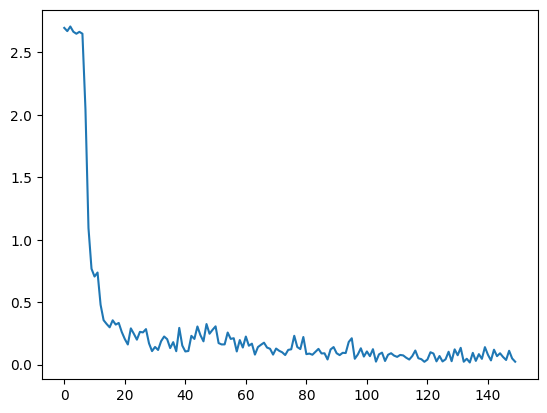

TypeError: save() missing 1 required positional argument: 'arr'

In [52]:
plt.plot(history)
plt.show()
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/ubermodellstmcnn.pdf")

(1092,) (1092,)


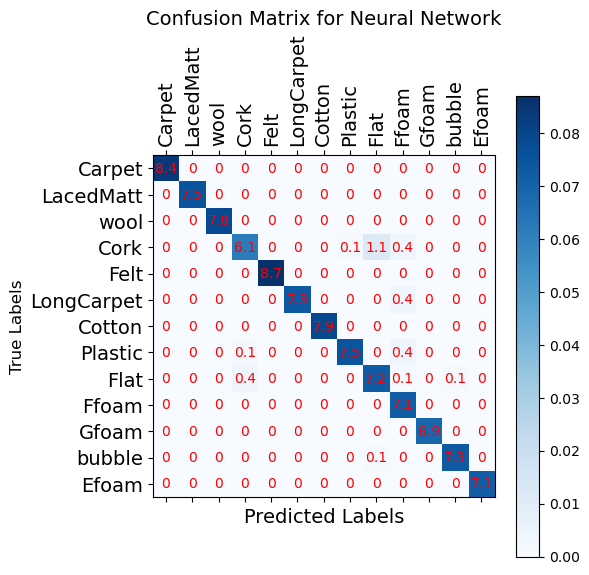

In [10]:
preds=None
real=None
keys=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'Cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'Jeans', 'Leather']
for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100) if round(value*100,1) == 0.0 else round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([keys[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([keys[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig(path+"/images/NM_confusionCNN.pdf")
plt.show()

In [31]:
torch.save(model.state_dict(), "C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel")


In [6]:
model = SimpleCNN(abs(0-4)*110,120,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv2.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([10, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 211200]) from checkpoint, the shape in current model is torch.Size([128, 33000]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([13, 128]) from checkpoint, the shape in current model is torch.Size([15, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([13]) from checkpoint, the shape in current model is torch.Size([15]).

In [15]:
#perform on unseen pressures

#load in numpy
data=np.load(datapath+"datasets/X_texture_pout.npz")
for array_name in data:
    x_unseen=(data[array_name].astype(np.uint8))
data=np.load(datapath+"datasets/y_texture_pout.npz")
for array_name in data:
    y_unseen=(data[array_name].astype(np.uint8))
print(x_unseen.shape)
#cut temporal size
x_unseen=x_unseen[:,0:4]
X=np.zeros_like(x_unseen)
#apply sobel filter
for i in range(len(x_unseen)): #crop all images individually
    for j in range(len(x_unseen[0])):
        image=x_unseen[i][j]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i][j]=sobel_combined
unique_=["Flat","wool","Efoam","LongCarpet","LacedMatt","cotton","Gfoam","Carpet","felt","Ffoam","bubble","Cork","Jeans"]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
        
unique_={i:keys[unique_[i]] for i in range(len(unique_))}

#concat
X=X.reshape((4,len(X)//4,1,abs(0-4)*110,120))
X=torch.tensor(X, dtype=torch.float32).to(device)
y=y_unseen.reshape(4,len(y_unseen)//4)
print(X.shape,unique_)
#run through model
predsA=torch.argmax(model(X[0]),axis=1).detach().numpy()
predsB=torch.argmax(model(X[1]),axis=1).detach().numpy()
predsC=torch.argmax(model(X[2]),axis=1).detach().numpy()
predsD=torch.argmax(model(X[3]),axis=1).detach().numpy()
data=np.array([predsA,predsB,predsC,predsD])
for i,batch in enumerate(data):
    for key in np.unique(batch):
        batch[batch==key]=unique_[key]
data=data.reshape((len(x_unseen)))
y=y.reshape((len(x_unseen)))

#show accuracy (maybe confusion matrix of sorts)
correct=0
summed=0.1
a=data==y
summed+=len(x_unseen)
correct+=len(a[a==1])
print("Accuracy:",(correct/summed)*100,"%")

(800, 20, 110, 120)
torch.Size([4, 200, 1, 440, 120]) {0: 16, 1: 19, 2: 21, 3: 25, 4: 28, 5: 29, 6: 30, 7: 31, 8: 34, 9: 36, 10: 37, 11: 38, 12: 39}
Accuracy: 99.9875015623047 %


# Vis

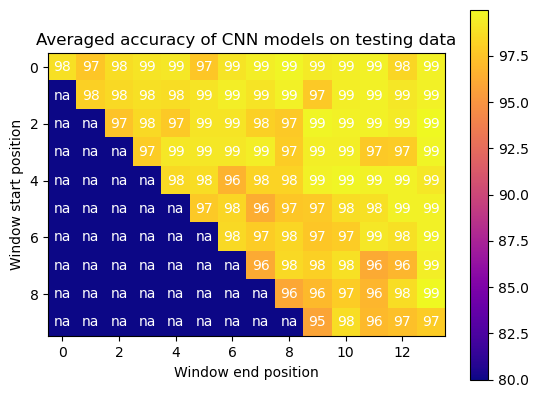

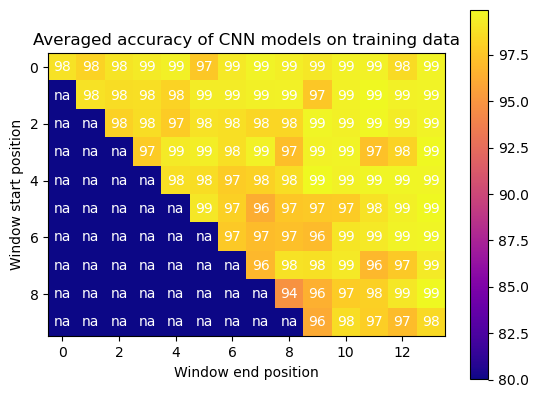

In [16]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()

## Feature layer

In [13]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()
sample_of_data=data.X[0:10]

model = SimpleCNN(abs(4)*data.X.shape[2],data.X.shape[3],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel"))
model.eval()


x_data=data.X[0:4].reshape((len(data.X[0:4]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)


Dataset size: 2600 
Window size: 20 
Image: (110, 120)
Memory needed: 0.64 GB


(110, 30)


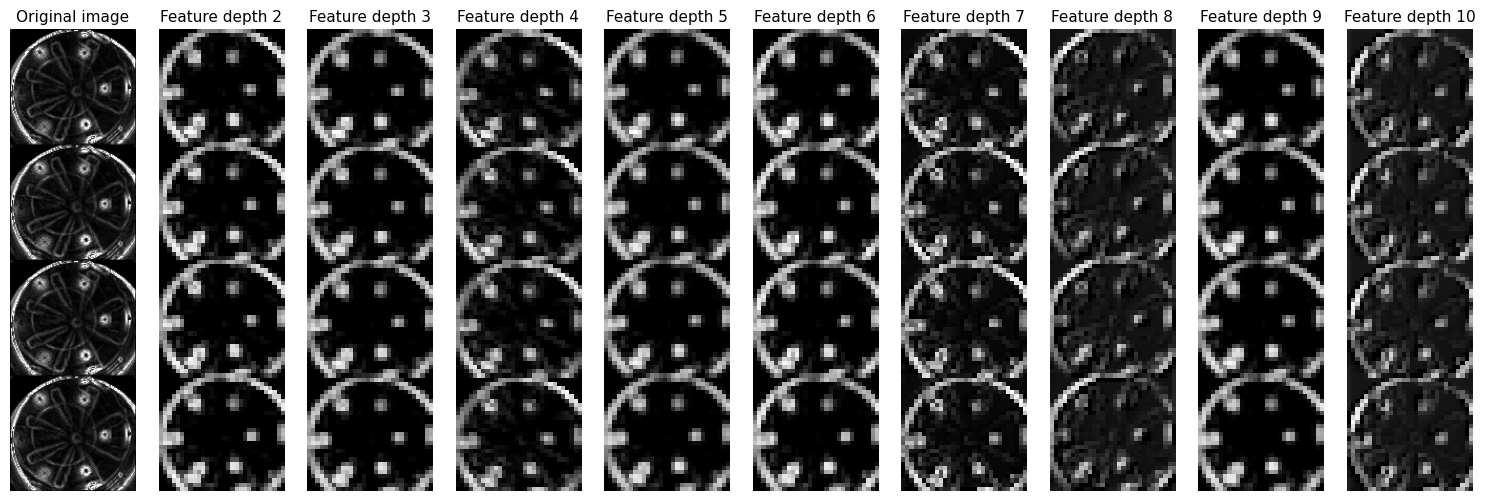

In [12]:

#forward pass
x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
print(x[0][0].shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(train_images_tensor[0][0].cpu().detach().numpy(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original image",fontsize=11)
for i in range(1,10):
    axes[i].imshow(x[2][i],cmap="gray")
    axes[i].axis("off")
    axes[i].set_title("Feature depth "+str(i+1),fontsize=11)
plt.tight_layout()
plt.savefig(path+"images/featuresALL_uberModel.pdf")
plt.show()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
(9000, 52800)


/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/its/home/drs25/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


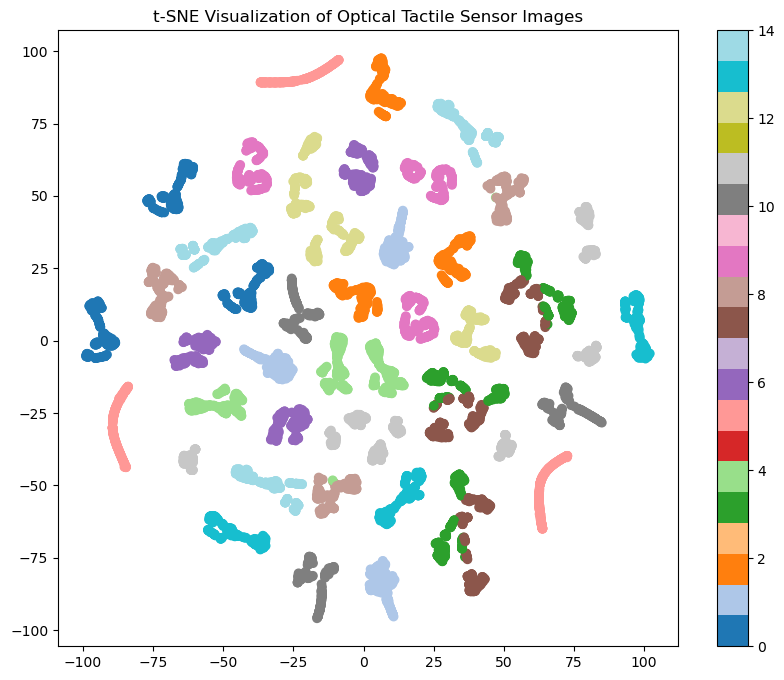

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data=loaded(t=4)
data.applySobel()
data.augment()

# Reduce dimensionality with PCA
pca = PCA(n_components=833)
x_data=data.X[0:].reshape((len(data.X[0:]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
labels=data.y[0:]
print(x_data.reshape(len(x_data), -1).shape)
pca_features = pca.fit_transform(x_data.reshape(len(x_data), -1))

# Further reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE Visualization of Optical Tactile Sensor Images')
plt.savefig(path+"/images/clusters.pdf")
plt.show()

# Point prediction

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

# Just points

In [47]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=5)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


(3000, 5, 110, 120)
(3000, 5, 110, 120) (3000, 5, 260, 270)


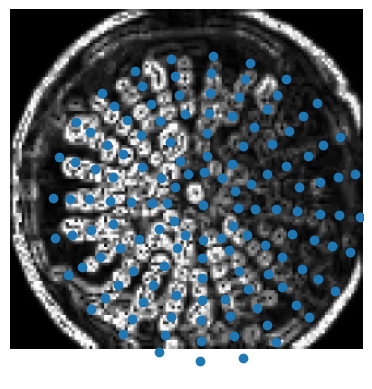

In [48]:
sample=data.X
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()
del sample
del X_prime
del X_alt

## FNN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_layer1_size)
        
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)


        self.fc3 = nn.Linear(hidden_layer2_size, 50)
        
        # Define the output fully connected layer
        self.fc4 = nn.Linear(50, output_size)
    
    def forward(self, x):
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        # Apply the output fully connected layer
        x = self.fc4(x)
        
        return x


In [99]:
X = np.round(coords.reshape((len(coords),-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
hidden_layer1_size = len(X[0]) //2  # Number of neurons in the first hidden layer
hidden_layer2_size = 800  # Number of neurons in the second hidden layer
output_size = len(un)     # Number of output features

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Print the model architecture
print(model)
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print(X.shape,y.shape,X.dtype,y.dtype)
# Create a TensorDataset and DataLoader
#dataset = TensorDataset(torch.Tensor(train_X).to(device), torch.Tensor(train_y).to(device))
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


SimpleNeuralNetwork(
  (fc1): Linear(in_features=1330, out_features=665, bias=True)
  (fc2): Linear(in_features=665, out_features=800, bias=True)
  (fc3): Linear(in_features=800, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=15, bias=True)
)
(3000, 1330) (3000, 15) float64 float64
Epoch [1/10000], Loss: 2.7115
Epoch [101/10000], Loss: 2.7079
Epoch [201/10000], Loss: 2.7067
Epoch [301/10000], Loss: 2.7059
Epoch [401/10000], Loss: 2.7050
Epoch [501/10000], Loss: 2.7038
Epoch [601/10000], Loss: 2.7015
Epoch [701/10000], Loss: 2.6968
Epoch [801/10000], Loss: 2.6842
Epoch [901/10000], Loss: 2.6351
Epoch [1001/10000], Loss: 2.7024
Epoch [1101/10000], Loss: 2.7108
Epoch [1201/10000], Loss: 2.5478
Epoch [1301/10000], Loss: 2.5203
Epoch [1401/10000], Loss: 2.8193
Epoch [1501/10000], Loss: 2.4334
Epoch [1601/10000], Loss: 2.5988
Epoch [1701/10000], Loss: 2.4162
Epoch [1801/10000], Loss: 2.4402
Epoch [1901/10000], Loss: 2.6450
Epoch [2001/10000], Loss: 2.6623
Epoch [210

In [100]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
39.666666666666664 %
(600, 15) (2400, 15)
42.375 %


In [16]:
coords.reshape((len(coords),-1)).shape

(3000, 1064)

## LSTM

In [15]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class SimpleLSTMDrop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(SimpleLSTMDrop, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [102]:
X = np.round(coords.reshape((len(coords),5,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 100, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 5, 266) (3000, 15) float64 (2400, 5, 266)
Epoch [100/10000], Loss: 0.0622
Epoch [200/10000], Loss: 0.0608
Epoch [300/10000], Loss: 0.0579
Epoch [400/10000], Loss: 0.0578
Epoch [500/10000], Loss: 0.0578
Epoch [600/10000], Loss: 0.0578
Epoch [700/10000], Loss: 0.0578
Epoch [800/10000], Loss: 0.0578
Epoch [900/10000], Loss: 0.0576
Epoch [1000/10000], Loss: 0.0560
Epoch [1100/10000], Loss: 0.0541
Epoch [1200/10000], Loss: 0.0535
Epoch [1300/10000], Loss: 0.0531
Epoch [1400/10000], Loss: 0.0509
Epoch [1500/10000], Loss: 0.0494
Epoch [1600/10000], Loss: 0.0494
Epoch [1700/10000], Loss: 0.0493
Epoch [1800/10000], Loss: 0.0493
Epoch [1900/10000], Loss: 0.0493
Epoch [2000/10000], Loss: 0.0493
Epoch [2100/10000], Loss: 0.0482
Epoch [2200/10000], Loss: 0.0470
Epoch [2300/10000], Loss: 0.0461
Epoch [2400/10000], Loss: 0.0461
Epoch [2500/10000], Loss: 0.0459
Epoch [2600/10000], Loss: 0.0458
Epoch [2700/10000], Loss: 0.0485
Epoch [2800/10000], Loss: 0.0425
Epoch [2900/10000], Loss: 0.0415
Epo

In [104]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
11.833333333333334 %
(600, 15) (2400, 15)
13.750000000000002 %


# Point velocities

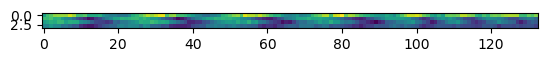

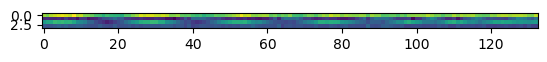

In [66]:
def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

#create dataset
d1=coords[:,:-1,:]
d2=coords[:,1:,:]
distances=np.linalg.norm(d1 - d2,axis=3)



## LSTM

In [119]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1200

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 4, 133) (3000, 15) float64 (2400, 4, 133)
Epoch [10/1200], Loss: 0.0601
Epoch [20/1200], Loss: 0.0585
Epoch [30/1200], Loss: 0.0574
Epoch [40/1200], Loss: 0.0556
Epoch [50/1200], Loss: 0.0541
Epoch [60/1200], Loss: 0.0532
Epoch [70/1200], Loss: 0.0522
Epoch [80/1200], Loss: 0.0517
Epoch [90/1200], Loss: 0.0501
Epoch [100/1200], Loss: 0.0496
Epoch [110/1200], Loss: 0.0488
Epoch [120/1200], Loss: 0.0479
Epoch [130/1200], Loss: 0.0481
Epoch [140/1200], Loss: 0.0471
Epoch [150/1200], Loss: 0.0472
Epoch [160/1200], Loss: 0.0455
Epoch [170/1200], Loss: 0.0447
Epoch [180/1200], Loss: 0.0452
Epoch [190/1200], Loss: 0.0437
Epoch [200/1200], Loss: 0.0435
Epoch [210/1200], Loss: 0.0431
Epoch [220/1200], Loss: 0.0420
Epoch [230/1200], Loss: 0.0430
Epoch [240/1200], Loss: 0.0425
Epoch [250/1200], Loss: 0.0412
Epoch [260/1200], Loss: 0.0404
Epoch [270/1200], Loss: 0.0460
Epoch [280/1200], Loss: 0.0410
Epoch [290/1200], Loss: 0.0400
Epoch [300/1200], Loss: 0.0392
Epoch [310/1200], Loss: 0.0417

In [120]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
75.33333333333333 %
(600, 15) (2400, 15)
82.5 %


In [112]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTMDrop(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(3000, 4, 133) (3000, 15) float64 (2400, 4, 133)
Epoch [10/600], Loss: 0.0716
Epoch [20/600], Loss: 0.0620
Epoch [30/600], Loss: 0.0606
Epoch [40/600], Loss: 0.0597
Epoch [50/600], Loss: 0.0592
Epoch [60/600], Loss: 0.0587
Epoch [70/600], Loss: 0.0582
Epoch [80/600], Loss: 0.0576
Epoch [90/600], Loss: 0.0574
Epoch [100/600], Loss: 0.0562
Epoch [110/600], Loss: 0.0555
Epoch [120/600], Loss: 0.0546
Epoch [130/600], Loss: 0.0534
Epoch [140/600], Loss: 0.0525
Epoch [150/600], Loss: 0.0513
Epoch [160/600], Loss: 0.0504
Epoch [170/600], Loss: 0.0494
Epoch [180/600], Loss: 0.0478
Epoch [190/600], Loss: 0.0465
Epoch [200/600], Loss: 0.0457
Epoch [210/600], Loss: 0.0452
Epoch [220/600], Loss: 0.0442
Epoch [230/600], Loss: 0.0426
Epoch [240/600], Loss: 0.0416
Epoch [250/600], Loss: 0.0405
Epoch [260/600], Loss: 0.0418
Epoch [270/600], Loss: 0.0404
Epoch [280/600], Loss: 0.0395
Epoch [290/600], Loss: 0.0403
Epoch [300/600], Loss: 0.0369
Epoch [310/600], Loss: 0.0356
Epoch [320/600], Loss: 0.0375


## FNN

In [91]:
X = distances.reshape((len(distances),-1))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 532) (3000, 15) float64 (2400, 532)
Epoch [1/10000], Loss: 2.7142
Epoch [101/10000], Loss: 2.7056
Epoch [201/10000], Loss: 2.6937
Epoch [301/10000], Loss: 2.6629
Epoch [401/10000], Loss: 2.6000
Epoch [501/10000], Loss: 2.5020
Epoch [601/10000], Loss: 2.3986
Epoch [701/10000], Loss: 2.3170
Epoch [801/10000], Loss: 2.2641
Epoch [901/10000], Loss: 2.2318
Epoch [1001/10000], Loss: 2.2112
Epoch [1101/10000], Loss: 2.1969
Epoch [1201/10000], Loss: 2.1857
Epoch [1301/10000], Loss: 2.1760
Epoch [1401/10000], Loss: 2.1672
Epoch [1501/10000], Loss: 2.1587
Epoch [1601/10000], Loss: 2.1503
Epoch [1701/10000], Loss: 2.1420
Epoch [1801/10000], Loss: 2.1339
Epoch [1901/10000], Loss: 2.1257
Epoch [2001/10000], Loss: 2.1174
Epoch [2101/10000], Loss: 2.1090
Epoch [2201/10000], Loss: 2.1007
Epoch [2301/10000], Loss: 2.0924
Epoch [2401/10000], Loss: 2.0843
Epoch [2501/10000], Loss: 2.0761
Epoch [2601/10000], Loss: 2.0679
Epoch [2701/10000], Loss: 2.0596
Epoch [2801/10000], Loss: 2.0512
Epoch [2901/

In [92]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
34.833333333333336 %
(600, 15) (2400, 15)
35.833333333333336 %


## CNN

In [109]:
X = np.round(distances.reshape((len(distances),1,4,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleCNN(len(distances[0]),len(distances[0][0]))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


(3000, 1, 4, 133) (3000, 15) float64 (2400, 1, 4, 133)
Epoch [10/10000], Loss: 0.0705
Epoch [20/10000], Loss: 0.0701
Epoch [30/10000], Loss: 0.0697
Epoch [40/10000], Loss: 0.0694
Epoch [50/10000], Loss: 0.0690
Epoch [60/10000], Loss: 0.0687
Epoch [70/10000], Loss: 0.0684
Epoch [80/10000], Loss: 0.0681
Epoch [90/10000], Loss: 0.0679
Epoch [100/10000], Loss: 0.0676
Epoch [110/10000], Loss: 0.0674
Epoch [120/10000], Loss: 0.0672
Epoch [130/10000], Loss: 0.0669
Epoch [140/10000], Loss: 0.0667
Epoch [150/10000], Loss: 0.0665
Epoch [160/10000], Loss: 0.0663
Epoch [170/10000], Loss: 0.0662
Epoch [180/10000], Loss: 0.0660
Epoch [190/10000], Loss: 0.0658
Epoch [200/10000], Loss: 0.0657
Epoch [210/10000], Loss: 0.0655
Epoch [220/10000], Loss: 0.0654
Epoch [230/10000], Loss: 0.0652
Epoch [240/10000], Loss: 0.0651
Epoch [250/10000], Loss: 0.0650
Epoch [260/10000], Loss: 0.0649
Epoch [270/10000], Loss: 0.0647
Epoch [280/10000], Loss: 0.0646
Epoch [290/10000], Loss: 0.0645
Epoch [300/10000], Loss: 0

In [111]:
inputs=torch.Tensor(test_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

(600, 15) (600, 15)
14.666666666666666 %
(600, 15) (2400, 15)
16.416666666666664 %


In [107]:
np.save(path+"/data/distances",distances)
np.save(path+"/data/distancesy",data.y)

# Transferability of normal model 

In [10]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodelgel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()
            

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 1.93 GB
Using 2.48 GB
torch.Size([6300, 1, 440, 120])
torch.Size([6300, 15])


/tmp/ipykernel_64935/3189561383.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [126/126], Loss: 328.2897
Epoch [11/100], Step [126/126], Loss: 21.4137
Epoch [21/100], Step [126/126], Loss: 3.7549
Epoch [31/100], Step [126/126], Loss: 0.9399
Epoch [41/100], Step [126/126], Loss: 0.2917
Epoch [51/100], Step [126/126], Loss: 0.1769
Epoch [61/100], Step [126/126], Loss: 0.1354
Epoch [71/100], Step [126/126], Loss: 0.1023
Epoch [81/100], Step [126/126], Loss: 0.0839
Epoch [91/100], Step [126/126], Loss: 0.0684
Finished Training


RuntimeError: Parent directory /model does not exist.

In [11]:

modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [22]:
print(calc(model,test_loader))
print(calc(model,train_loader))

import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p

Accuracy: 99.83334655979685 %
0.9983334655979685
Accuracy: 99.99801591238268 %
0.9999801591238269
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [13]:
sample=data.X[0:300]
X_prime=np.zeros((len(sample),sample.shape[1],*data.X[0][0].shape),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2)).astype(np.uint16)
divh=X_prime[0][0].shape[0]/270
divw=X_prime[0][0].shape[1]/260
print(divh,divw,X_prime[0][0].shape)
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        temp=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=np.round(predict(reg,temp)[0])
        #X_prime[i][j]*=0 
        for point in zip(coords[i][j][:,0],coords[i][j][:,1]):
            p1=int(point[0]*divh)
            p2=int(point[1]*divw)
            cv2.circle(X_prime[i][j],(p1,p2),1,(255),2)
del sample

0.4074074074074074 0.46153846153846156 (110, 120)


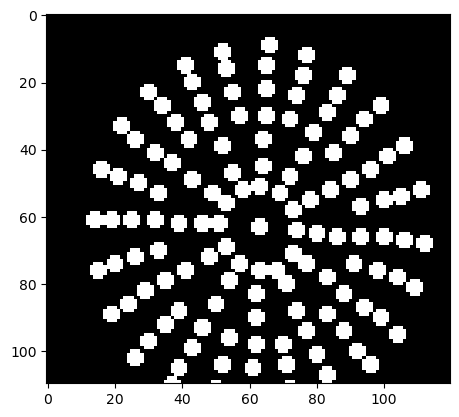

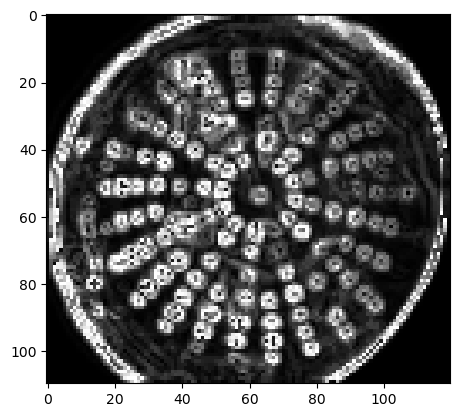

In [190]:
plt.imshow(X_prime[0][0],cmap="gray")
plt.show()
plt.imshow(data.X[0][0],cmap="gray")
plt.show()

In [49]:
x=(X_prime-np.mean(X_prime))/(np.max(X_prime)-np.min(X_prime))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")


(300, 1, 440, 120)
torch.float32
6.0 %


# saliency maps

In [25]:
data=loaded(4,filename="X_data_nomarker.npz")
data.applySobel()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [26]:
image=data.X[0][0]
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodelnomarker"))
model.eval()
n=10


/tmp/ipykernel_194356/2032115766.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodelnomarker"))


torch.Size([10, 1, 440, 120])


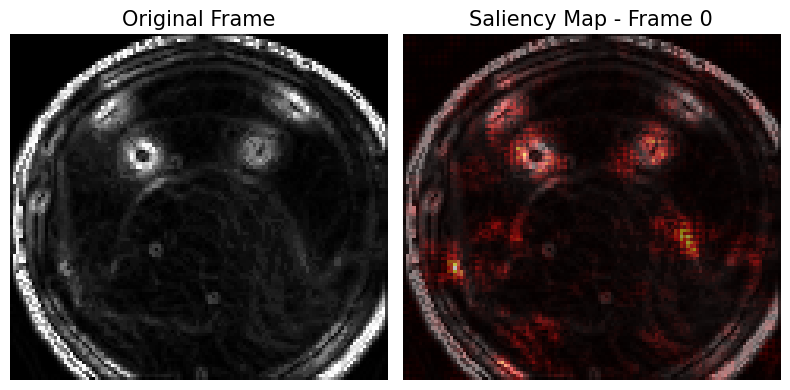

In [28]:
#look at frquency 
def generate_saliency_maps(model, inputs, target_class):
    model.eval()
    inputs.requires_grad = True  # Ensure gradients can be computed for input

    # Forward pass to get the predictions
    outputs = model(inputs)  # outputs should be of shape (N, num_classes) if model outputs logits
    score = outputs[:, target_class].sum()  # Sum over the batch for a single target class
    
    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the absolute value of the gradients as saliency map
    saliency = inputs.grad.abs()  # Shape will be (N, t, w, h)

    return saliency

# Plotting Function
def plot_saliency_map(saliency, original_frames, time_index):
    """Plot saliency map for a specific time index in the sequence"""
    # Average over the batch if needed, to show a single example
    saliency_frame = saliency[0, time_index].detach().cpu().numpy()  # Shape (w, h)
    original_frame = original_frames[0, time_index].detach().cpu().numpy()
    
    # Normalize saliency map for visualization
    saliency_frame = (saliency_frame - saliency_frame.min()) / (saliency_frame.max() - saliency_frame.min())
    
    # Plot the original frame with saliency map overlay
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].imshow(original_frame[0:110,:], cmap='gray')
    ax[0].set_title("Original Frame",fontsize=15)
    ax[0].axis('off')
    ax[1].imshow(original_frame[0:110,:], cmap='gray')
    ax[1].imshow(saliency_frame[0:110,:], cmap='hot', alpha=0.5)  # Overlay saliency map
    ax[1].set_title(f"Saliency Map - Frame {time_index}",fontsize=15)
    ax[1].axis('off')
    plt.tight_layout()
    plt.savefig(path+"/images/saliency_map.pdf")
    plt.show()

# Load a sample from your dataset
shape=data.X[0].shape
n=10
sample_input = torch.tensor(data.X[0:n],dtype=torch.float32).reshape((len(data.X[0:n]),1,4*data.X.shape[2],data.X.shape[3]))  # Shape (1, t, w, h) - single sample for visualization

print(sample_input.shape)
# Generate saliency maps for the sample
target_class = 0  # Replace with the class index of interest
saliency_maps = generate_saliency_maps(model, sample_input, target_class)

# Plot saliency for each frame in the temporal sequence
for time_index in range(sample_input.shape[1]):  # Iterate over t frames
    plot_saliency_map(saliency_maps, sample_input, time_index)

## Taking out segments



In [15]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


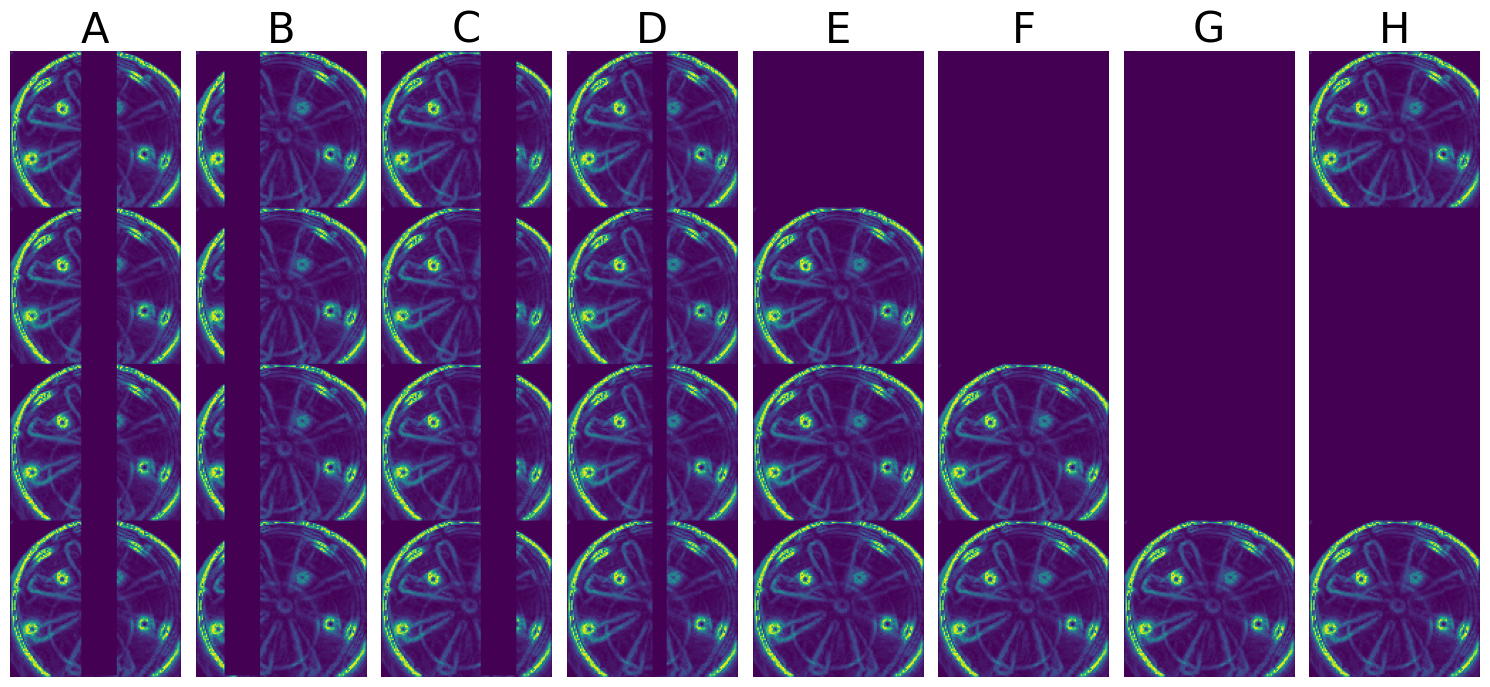

In [20]:

sample=data.X[0:300].reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
images=[sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy()]
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
label=["50:75","20:45","70:95","60:70","Segment removed","Two removed","Three removed","Only first and last"]
label=["A","B","C","D","E","F","G","H"]
sample[:,0:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy()

fig, axes = plt.subplots(1, len(images), figsize=(15,8))
axes = axes.flatten()
for i in range(len(images)):
    axes[i].set_title(label[i],fontsize=30)
    axes[i].imshow(images[i])
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(path+"/images/samplesCrops_.pdf")
plt.show()


(440, 120)
(300, 1, 440, 120)
torch.float32


/tmp/ipykernel_195787/3142934358.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))


68.66666666666667 %


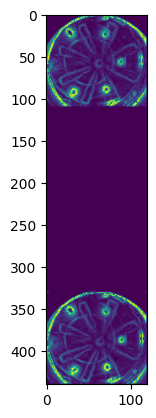

In [23]:
sample=data.X[0:300].reshape((300,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
"""
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
"""
sample[:,110:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy() # lstm
sample=sample.reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()

image=sample[0][0]
print(image.shape)
#model=SimpleCNN(data.X.shape[2]*4,data.X.shape[3],15).to(device)#.half()
"""model=SimpleLSTM(image.shape[1],1000,15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()"""
model = SimpleCNN(image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
#x=x.reshape((len(x),4,x.shape[2]//4*x.shape[3]))

print(x.shape)
test=torch.tensor(x, dtype=torch.float32).to(device)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")
plt.imshow(image.reshape((4*len(data.X[0][0]),len(data.X[0][0][0]))))
plt.show()

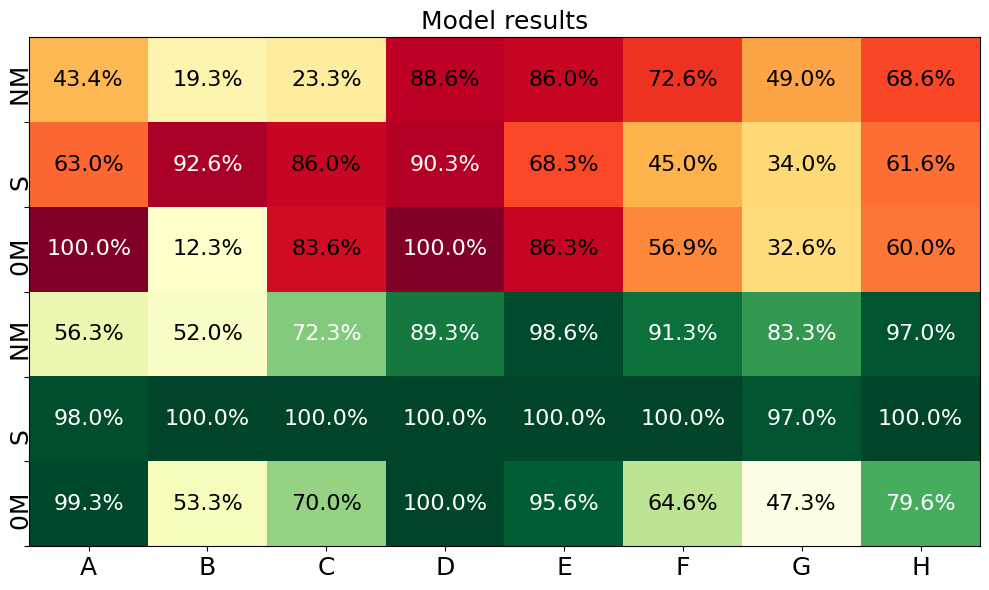

In [24]:
matrixA=np.array([[56.3,98,99.3],[52,100,53.3],[72.3,100,70],[89.33,100,100],[98.6,100,95.6],[91.3,100,64.6],[83.3,97,47.3],[97,100,79.6]]) #cnn
matrixB=np.array([[43.4,63,100],[19.3,92.6,12.3],[23.3,86,83.6],[88.6,90.3,100],[86,68.3,86.3],[72.6,45,56.9],[49,34,32.6],[68.6,61.6,60]])
fig, ax = plt.subplots(figsize=(10, 6))

# Plot matrixA in the top half with 'YlGn' colormap
ax.imshow(matrixA.T, cmap='YlGn', aspect='auto', extent=[0, 8, 6, 3])

# Plot matrixB in the bottom half with 'gray' colormap
ax.imshow(matrixB.T, cmap='YlOrRd', aspect='auto', extent=[0, 8, 3, 0])

# Set ticks
ax.set_xticks(np.arange(8) + 0.5)
ax.set_xticklabels(["A","B","C","D","E","F","G","H"],fontsize=18)
ax.set_yticks(np.arange(6)+1)
ax.set_yticklabels(["  NM", "  S", "  0M", "  NM", "  S", "  0M"], rotation=90, ha="left", rotation_mode="anchor",fontsize=18)


# Add text annotations
for i in range(matrixA.shape[0]):
    for j in range(matrixA.shape[1]):
        ax.text(i+0.5, j+0.5+3, f"{matrixA[i, j]:.1f}%", ha='center', va='center', color='white' if matrixA[i, j] > 70 else 'black',fontsize=16)

for i in range(matrixB.shape[0]):
    for j in range(matrixB.shape[1]):
        ax.text(i+0.5, j+0.5, f"{matrixB[i, j]:.1f}%", ha='center', va='center', color='white' if matrixB[i, j] > 90 else 'black',fontsize=16)


plt.title("Model results",fontsize=18)
plt.tight_layout()
plt.savefig(path+"/images/LSTM_different_markers.pdf")
plt.show()

# Different pressures

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodel_withLowPressure") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
print(calc(model,test_loader))
print(calc(model,train_loader))

In [11]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()
#print(calc(model,test_loader))
#print(calc(model,train_loader))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleLSTM(
  (lstm): LSTM(13200, 1000, batch_first=True)
  (fc): Linear(in_features=1000, out_features=15, bias=True)
)

In [12]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
d.applySobel()
sample=d.X
label=d.y


Dataset size: 800 
Window size: 20 
Image: (110, 120)
Memory needed: 0.2 GB


In [14]:
sample=d.X
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),x.shape[1],x.shape[2]*x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds[preds==11]
print(len(a)/len(preds) *100,"%")
del test
del x

100.0 %


In [16]:
p20=d.X[np.where(d.y==3)]
p30=d.X[np.where(d.y==0)]
p40=d.X[np.where(d.y==2)]
p50=d.X[np.where(d.y==1)]
data=[p20,p30,p40,p50]
accs=[]
for i in range(4):
    sample=data[i]
    label=11
    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))  #n,1,t*h,w for cnn, n,t,h*w for lstm, n,1,t,h,w for cnn-lstm
    test=torch.tensor(x, dtype=torch.float32).to(device)
    preds=model(test)
    preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
    a=len(preds[preds==label])
    print(a/len(preds) *100,"%")

ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

# models on other data sets

In [6]:
data=loaded(4,filename="X_data_nomarker.npz")
image=data.X[0][0].copy()
del data
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#print(calc(model,test_loader))
#print(calc(model,train_loader))

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [14]:
#model=SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)
model=CNN_LSTM(image.shape[1],image.shape[0],1000,1,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_lstmCNN"))
model.eval()

CNN_LSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(33000, 1000, batch_first=True)
  (fc): Linear(in_features=1000, out_features=15, bias=True)
)

In [15]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_data_nomarker.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
sample=d.X[0:800]
label=d.y[0:800]
del d
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1],x.shape[2],x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds-label
print(len(a[a==0])/len(preds) *100,"%")
del test
del x


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
13.125 %


# Transferring large models to small

In [6]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [17]:
d=loaded(t=4,filename="X_data_15.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
d.resize(0.1)

sample=d.X
sampley=d.y
image=sample[0][0]
print(image.shape)
#copy over correct convolutions
modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],15).to(device)
modelB.conv1=model.conv1
modelB.conv2=model.conv2
#freeze conv layers
modelB.conv1.requires_grad=False
modelB.conv2.requires_grad=False


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
(11, 12)


In [18]:


label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(sampley)
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)


/tmp/ipykernel_15726/3748773328.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


In [19]:
#train
train_history=[]
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(modelB.parameters(), lr=0.005)

# Train the Model
num_epochs=50
clip_value = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = modelB(inputs)
        #print(inputs.shape,outputs.shape,labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    train_history.append(loss.cpu().detach().numpy())
    if epoch%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
print('Finished Training')

Epoch [1/50], Step [60/60], Loss: 148.3680
Epoch [11/50], Step [60/60], Loss: 71.8048
Epoch [21/50], Step [60/60], Loss: 53.7685
Epoch [31/50], Step [60/60], Loss: 44.4859
Epoch [41/50], Step [60/60], Loss: 35.9675
Finished Training


In [20]:
print(calc(modelB,test_loader))
print(calc(modelB,train_loader))

Accuracy: 85.48575237460423 %
0.8548575237460423
Accuracy: 87.37135952668639 %
0.8737135952668639


In [ ]:
#GEL
# 5%
# train % 58.95 test 57.99 % 

#10%
# train % 91.70 test 92.81 % 

#15%
# train % 93.37 test 94.81

#20%
# train % 96.99 test 98.15

#25%
# train % 99.9 test 99.98 % 

#NEWMORPH
# 5%
# train % 74.32 test 75.37 % 

#10%
# train % 89.17 test 89.02 % 

#15%
# train % 82.92 test 84.98 %

#20%
# train % 96.87 test 95.75 %

#25%
# train % 90.1 test 88.25 % 

#SILICONE
# 5%
# train % - test - % 

#10%
# train % - test - % 

#15%
# train % 79 test 74 %

#20%
# train % 88 test 90 %

#25%
# train % - test - % 

## automate

In [12]:
#automate the shit out of it
def long(file,type1,num):
    resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
    acc_test=np.zeros((len(resolution),5))
    acc_train=np.zeros((len(resolution),5))
    num_epochs=80
    history=np.zeros((len(resolution),5,num_epochs))

    for i in range(len(resolution)):
        d=loaded(t=4,filename=file) #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
        d.applySobel()
        image=d.X[0][0]
        model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
        model.load_state_dict(torch.load(path+"/model/mymodelgel"))
        model.eval()
        d.resize(resolution[i])
        
        sample=d.X
        sampley=d.y
        image=sample[0][0]
        print(image.shape)
        
        #copy over correct convolutions
        modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],num).to(device)
        modelB.conv1=model.conv1
        modelB.conv2=model.conv2
        #freeze conv layers
        modelB.conv1.requires_grad=False
        modelB.conv2.requires_grad=False


        label_encoder = LabelEncoder()
        train_labels_encoded = label_encoder.fit_transform(sampley)
        one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
        x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
        x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

        train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

        # Create a TensorDataset
        dataset = TensorDataset(train_images_tensor, train_labels_tensor)
        # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create DataLoader for training and testing sets
        train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
        max_=0
        for j in range(5):
            clear_output(wait=True)
            print("Resolution",resolution[i],"Trial",j)
            criterion = nn.CrossEntropyLoss().to(device)
            optimizer = optim.SGD(modelB.parameters(), lr=0.005)

            # Train the Model
            
            clip_value = 5
            for epoch in range(num_epochs):
                running_loss = 0.0
                for k, (inputs, labels) in enumerate(train_loader):
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = modelB(inputs)
                    #print(inputs.shape,outputs.shape,labels.shape)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
                    optimizer.step()

                    # Print statistics
                    running_loss += loss.item()
                history[i][j][epoch]=running_loss/(k+1) #save average loss per epoch
            test=calc(modelB,test_loader)
            train=calc(modelB,train_loader)
            acc_train[i][j]=train
            acc_test[i][j]=test
            if test>max_:
                max_=test
                torch.save(modelB.state_dict(), path+"/model/standard_c_gel/cnn_res"+str(resolution[i])+"_"+str(type1))
        del train_loader
        del test_loader
    
    np.save(path+"/data/train_uber_"+type1+"_long_standard_c",acc_train)
    np.save(path+"/data/test_uber_"+type1+"_long_standard_c",acc_test)
    np.save(path+"/data/histroy_"+type1+"_long_standard_c",history)

#X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
long("X_data_gel_15.npz","gel",15)
#long("X_data_15.npz","sil",15)
#long("X_data_newMorph.npz","nm",13)


Resolution 0.8 Trial 4
Accuracy: 99.98333611064822 %
Accuracy: 99.99583350693722 %


## vis

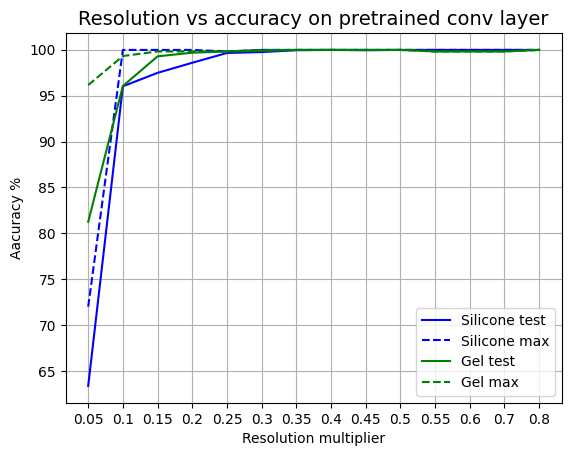

In [14]:
sil_train=np.load(path+"/data/train_uber_sil_long_standard_c.npy")
sil_test=np.load(path+"/data/test_uber_sil_long_standard_c.npy")
gel_train=np.load(path+"/data/train_uber_gel_long_standard_c.npy")
gel_test=np.load(path+"/data/test_uber_gel_long_standard_c.npy")
#nm_train=np.load(path+"/data/train_uber_nm_long.npy")
#nm_test=np.load(path+"/data/test_uber_nm_long.npy")

average_sil_test=np.average(sil_test,axis=1)*100
max_sil_test=np.max(sil_test,axis=1)*100
average_sil_train=np.average(sil_train,axis=1)*100
average_gel_test=np.average(gel_test,axis=1)*100
max_gel_test=np.max(gel_test,axis=1)*100
average_gel_train=np.average(gel_train,axis=1)*100
#average_nm_test=np.average(nm_test,axis=1)*100
#max_nm_test=np.max(nm_test,axis=1)*100
#average_nm_train=np.average(nm_train,axis=1)*100

plt.plot(average_sil_test,c="b",label="Silicone test")
plt.plot(max_sil_test,"--",c="b",label="Silicone max")
plt.plot(average_gel_test,c="g",label="Gel test")
plt.plot(max_gel_test,"--",c="g",label="Gel max")
#plt.plot(average_nm_test,c="r",label="NM test")
#plt.plot(max_nm_test,"--",c="r",label="NM max")

#plt.plot(average_sil_train,c="b",label="Silicone train")
resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
plt.xticks([i for i in range(len(resolution))],resolution)
plt.ylabel("Aacuracy %")
plt.xlabel("Resolution multiplier")
plt.title("Resolution vs accuracy on pretrained conv layer",fontsize=14)
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(path+"/images/resolution_just_own_transfer.pdf")
plt.show()

(14, 5, 80)
(14, 80)


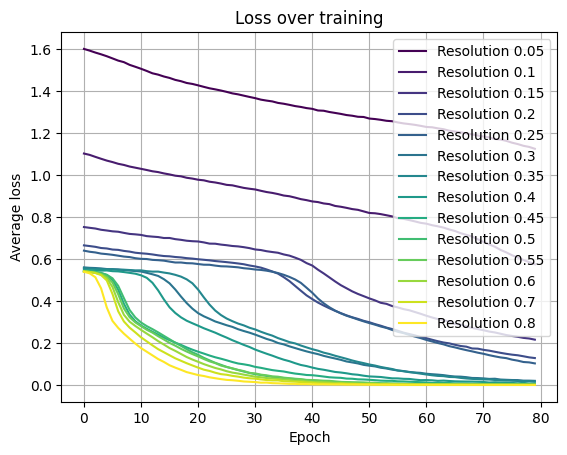

In [113]:
import matplotlib.cm as cm

sil_history=np.load(path+"/data/histroy_sil_long_untrained.npy")
gel_history=np.load(path+"/data/histroy_gel_long_untrained.npy")
nm_history=np.load(path+"/data/histroy_nm_long_untrained.npy")
print(sil_history.shape)

sil_history_av=np.average(sil_history,axis=1)
#gel_history_av=np.average(gel_history,axis=1)
#nm_history_av=np.average(nm_history,axis=1)
print(sil_history_av.shape)
# Create a colormap that gets darker
colors = cm.viridis(np.linspace(0, 1, len(resolution)))

for i in range(len(sil_history_av)):
    plt.plot(sil_history_av[i],color=colors[i],label="Resolution "+str(resolution[i]))
#plt.plot(gel_history_av,label="Average loss gel")
#plt.plot(nm_history_av,label="Average loss new morphology")
plt.title("Loss over training")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig(path+"/images/resolution_loss_untrained.pdf")
plt.show()

## Feature layers

In [15]:
images_X=[]
images_f=[]
images_o=[]
for i in range(len(resolution)-1):
    filename="cnn_res"+str(resolution[i])+"_gel"

    data=loaded(4,filename="X_data_15.npz")
    data.applySobel()
    data.resize(resolution[i])
    image=data.X[0][0]

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/res/"+filename))
    model.eval()

    sample=data.X[0:13]
    sampley=data.y[0:13]

    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

    train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_X.append(train_images_tensor[0][0].cpu().detach().numpy())
    images_f.append(x.copy())

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/learnedres/"+filename))
    model.eval()

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_o.append(x.copy())


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory ne

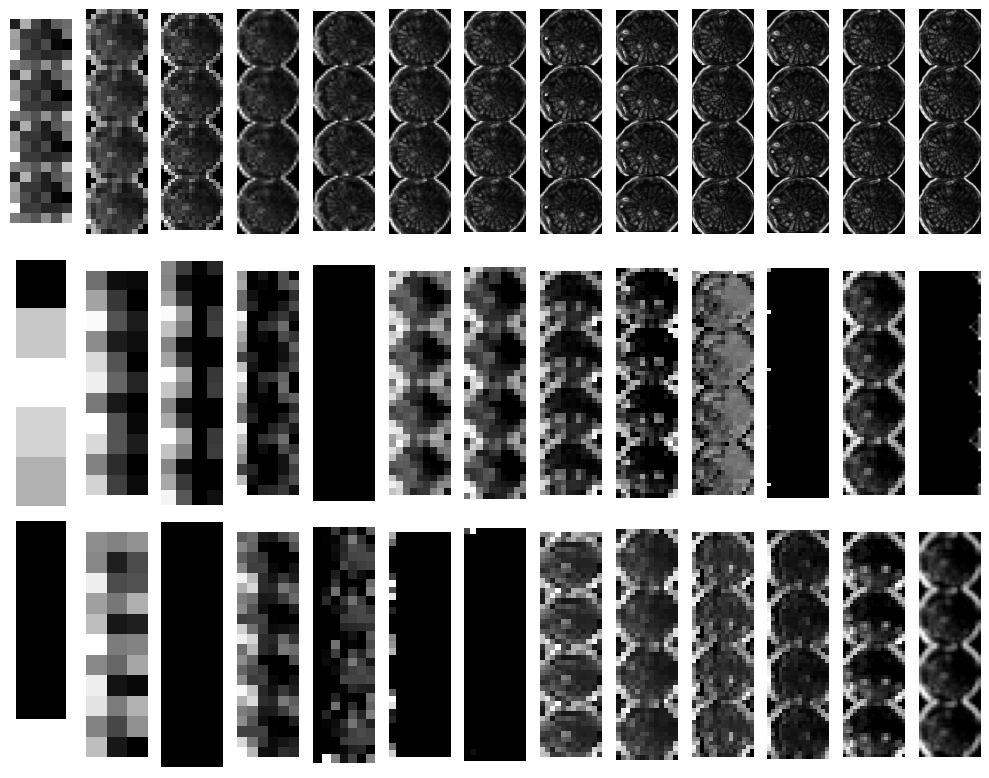

In [17]:

fig, axes = plt.subplots(3, len(resolution)-1, figsize=(10, 8))
#axes = axes.flatten()

for i in range(len(images_X)):
    axes[0][i].imshow(images_X[i],cmap="gray")
    axes[0][i].axis("off")
    axes[0][i].set_ylabel("Original res "+str(resolution[i]),fontsize=11)
    #print(images_f[i][0].shape)
    axes[1][i].imshow(images_f[i][0][0],cmap="gray")
    axes[1][i].axis("off")
    #axes[1][i].set_title("Feature res"+str(resolution[i]),fontsize=11)
    axes[2][i].imshow(images_o[i][1][0],cmap="gray")
    axes[2][i].axis("off")

plt.tight_layout()
plt.savefig(path+"images/features_norm_transfer.pdf")
plt.show()